<a href="https://colab.research.google.com/github/cosineDaDa0623/2023_Summer_Intern/blob/master/Pytorch_dc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version
!nvcc --version

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
#install the related packages
!pip install rdkit
!pip install deepchem[torch]
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 57.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.5.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.2
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0


# Packages Import

In [3]:
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import pandas as pd #Pandas have Dataframe, so the manipulation of data is efficient and convenient
import numpy as np #Linear math packages, which are important for the data
from google.colab import drive #Just used to get file from the google drive
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils import data
from torch import nn
drive.mount('/content/drive')
# df = pd.read_excel('/content/drive/MyDrive/5HT2A models data.xlsx')
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

Mounted at /content/drive


In [14]:
import matplotlib.pyplot as plt

# Data preprocessing
The commented code is used to genereate label, so that the label can be used in the training and testing

In [ ]:
# def get_response(ligand_class):
#   convert_dic = {
#       'dude_active' : 0,
#       'dude_inactive' : 1,
#       'HTR2A_Antagonist_1.0' : 2,
#       'HTR2A_Antagonist_0.0' : 3,
#       'HTR2A_Agonist_1.0' : 4,
#       'HTR2A_Agonist_0.0' : 5,
#       'HTR2A_Inverse Agonist_1.0' : 6
# }
#   return convert_dic[ligand_class]

# df['label'] = df['ligand_class'].apply(get_response)

In [ ]:
# df['label'].unique()

array([0, 1, 2, 4, 5, 3, 6])

In [ ]:
# df.to_csv('/content/drive/MyDrive/5HT2A models data.csv')

In [4]:
dataset_file = '/content/drive/MyDrive/5HT2A models data.csv' # load the data which has been preprocessed
task_list = ['label']
featurizer_func = dc.feat.CircularFingerprint(size = 2048, radius = 4) # here we use ECFP featurizer

In [5]:
loader = dc.data.CSVLoader(tasks=task_list, feature_field='smiles', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file) #create the dataset, type:diskdataset

In [6]:
scaffoldsplitter = dc.splits.ScaffoldSplitter() #split the dataset into train, validate, and test datasets by using the scffold
test_dataset, vadid_dataset, test_dataset = scaffoldsplitter.train_valid_test_split(dataset, frac_train = 0.7, frac_valid = 0.15, frac_test = 0.15, seed = 23)

In [7]:
tt = test_dataset.make_pytorch_dataset(batch_size = 64)
va = vadid_dataset.make_pytorch_dataset(batch_size = 64)
te = test_dataset.make_pytorch_dataset(batch_size = 64)

This is a illustration of the input, we wiil use this for the model we build
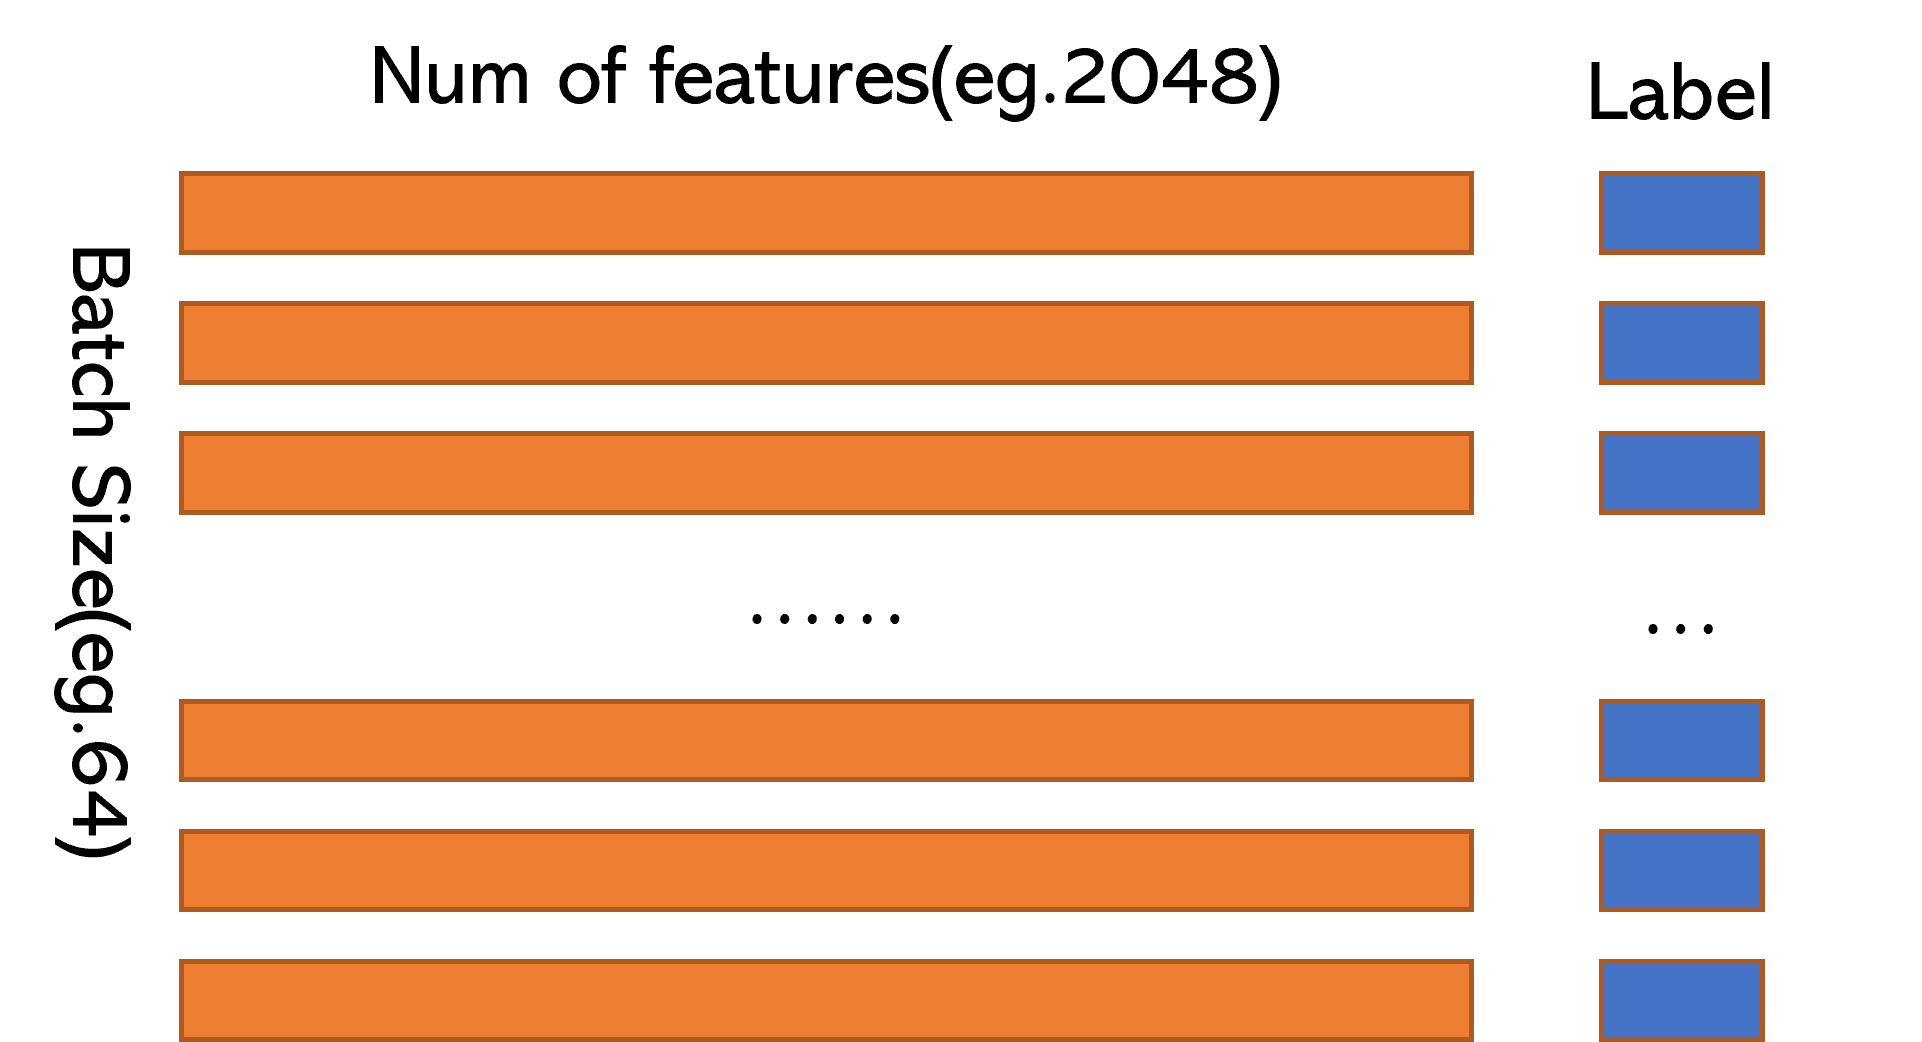

# Model defining

In [ ]:
#Import Pytorch which is a commonly-used deeplearning package

class NN1(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layers = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 7)
    )

  def forward(self, x):
    return self.linear_layers(x)



In [8]:
# This one is a general NN for Hyperparameters searching, you can build different NN convenniently
class HPO_NN(nn.Module):
  def __init__(self, num_features, layer_sizes_list, dropout_list, num_of_class = 7):
    super().__init__()
    last_layer = num_features
    layers_list = []
    assert(len(layer_sizes_list) == len(dropout_list))
    for layer_i, dropout_i in zip(layer_sizes_list, dropout_list):
      layers_list.extend([
        nn.Linear(last_layer, layer_i),
        nn.BatchNorm1d(layer_i),
        nn.ReLU(),
        nn.Dropout(dropout_i)
      ])
      last_layer = layer_i
    layers_list.append(nn.Linear(last_layer, num_of_class))
    self.linear_layers = nn.Sequential(*layers_list)
  def forward(self, x):
    return self.linear_layers(x)

# Train and Test loop

In [9]:
# Set the device to GPU if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_loop(dataloader, model, loss_fn, optimizer):
    # Set model to training mode; this is crucial for certain layers like Dropout and BatchNorm
    model.train()
    # Transfer model to the computation device (either GPU or CPU)
    model.to(device)

    # Iterate through batches of data from the dataloader
    for batch, (X, y, _, _) in enumerate(dataloader):
        # Convert data to tensors and transfer them to the computation device
        X = torch.tensor(X).float().to(device)
        y = torch.tensor(y).long().to(device)
        y = y.squeeze(1)  # Remove any unnecessary dimensions

        # Pass data through model to get predictions
        pred = model(X)
        # Compute the loss between predictions and true labels
        loss = loss_fn(pred, y)

        # Backpropagation steps
        optimizer.zero_grad()  # Clear out any accumulated gradients
        loss.backward()  # Compute the gradients
        optimizer.step()  # Update the model's weights

        # Print the loss for every 100 batches to monitor training
        if batch % 100 == 0:
            print(f"Train_loss: {loss.item():>7f}")

def test_loop(dataloader, model, loss_fn):
    # Set model to evaluation mode; this affects layers like Dropout and BatchNorm
    model.eval()
    # Transfer model to the computation device
    model.to(device)

    size = len(dataloader.disk_dataset)
    num_batches = 0
    test_loss, correct = 0, 0
    all_true_labels = []
    all_predicted_labels = []

    # Ensure no gradient computation for this block (saves memory and computations)
    with torch.no_grad():
        for (X, y, _, _) in dataloader:
            # Convert data to tensors and transfer them to the computation device
            X = torch.tensor(X).float().to(device)
            y = torch.tensor(y).long().to(device)
            y = y.squeeze(1)

            # Get predictions from the model
            pred = model(X)
            # Accumulate the loss
            test_loss += loss_fn(pred, y).item()
            # Count the number of correct predictions
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Store the true and predicted labels for metrics computation
            all_true_labels.extend(y.cpu().tolist())
            all_predicted_labels.extend(pred.argmax(1).cpu().tolist())
            num_batches += 1

    test_loss /= num_batches  # Average loss
    correct /= size  # Accuracy

    # Compute additional metrics
    precision = precision_score(all_true_labels, all_predicted_labels, average='macro')
    recall = recall_score(all_true_labels, all_predicted_labels, average='macro')
    f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')
    mcc = matthews_corrcoef(all_true_labels, all_predicted_labels)

    # Print evaluation results
    print(f"Test Error: ")
    print(f" Accuracy: {(100*correct):>0.1f}%")
    print(f" Avg loss: {test_loss:>8f}")
    print(f" Precision: {precision:>0.4f}")
    print(f" Recall: {recall:>0.4f}")
    print(f" F1 Score: {f1:>0.4f}")
    print(f" Matthew's Correlation Coefficient: {mcc:>0.4f}")

    return 100*correct

# Add early-stopping

In [10]:
import torch  # Adding import statement for torch

class EarlyStopping:
    """
    EarlyStopping can be used to stop the training when a monitored metric has stopped improving.
    """

    def __init__(self, patience=10):
        """
        Initializes the EarlyStopping object.

        :param patience: Number of epochs with no improvement after which training will be stopped.
        """
        self.patience = patience  # How long to wait after last time validation loss improved.
        self.counter = 0         # Counter for epochs with no improvement.
        self.best_score = None   # Best score observed so far.
        self.early_stop = False  # A flag to indicate if stopping of training is required.

    def __call__(self, test_loss, model):
        """
        Call to check if early stopping should be executed or not.

        :param test_loss: Current loss value to be checked.
        :param model: The model instance which is currently being trained.
        """

        # If best_score hasn't been set yet, set it as the current loss.
        if self.best_score is None:
            self.best_score = test_loss
            self.save_checkpoint(model)
        # If current test loss is more than the best score, then increase the counter.
        elif test_loss <= self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            # If counter exceeds patience, then it's time to stop training.
            if self.counter >= self.patience:
                self.early_stop = True
        # If current test loss is less than the best score, reset the counter and save this model.
        else:
            self.best_score = test_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """
        Saves the model when called.

        :param model: The model instance to be saved.
        """
        # Save the model's state_dict. The path specified here can be customized as needed.
        torch.save(model.state_dict(), '/content/drive/MyDrive/checkpoint.pt')


In [ ]:
nn2 = HPO_NN(2048, [1024, 512, 256], [0.5, 0.5, 0.5])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn2.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=10)
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(tt, nn2, loss_fn, optimizer)
    test_loss = test_loop(va, nn2, loss_fn)
    early_stopping(test_loss, nn2)
    if early_stopping.early_stop:
        print("Early stopping")
        break
print("Done!")

Epoch 1
-------------------------------
Train_loss: 2.140125
Train_loss: 1.139923


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 72.7%
 Avg loss: 1.164545
 Precision: 0.3603
 Recall: 0.3626
 F1 Score: 0.3604
 Matthew's Correlation Coefficient: 0.5515
Epoch 2
-------------------------------
Train_loss: 1.143839
Train_loss: 0.566293


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.6%
 Avg loss: 0.920281
 Precision: 0.3574
 Recall: 0.3926
 F1 Score: 0.3656
 Matthew's Correlation Coefficient: 0.6045
Epoch 3
-------------------------------
Train_loss: 1.030624
Train_loss: 0.610083


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.7%
 Avg loss: 0.824004
 Precision: 0.3634
 Recall: 0.3999
 F1 Score: 0.3704
 Matthew's Correlation Coefficient: 0.6264
Epoch 4
-------------------------------
Train_loss: 0.432009
Train_loss: 0.599566


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.6%
 Avg loss: 0.821514
 Precision: 0.3626
 Recall: 0.3995
 F1 Score: 0.3643
 Matthew's Correlation Coefficient: 0.6208
EarlyStopping counter: 1 out of 10
Epoch 5
-------------------------------
Train_loss: 0.383503
Train_loss: 0.291129


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 0.766771
 Precision: 0.3670
 Recall: 0.4050
 F1 Score: 0.3720
 Matthew's Correlation Coefficient: 0.6374
Epoch 6
-------------------------------
Train_loss: 0.420419
Train_loss: 0.381318


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 0.757699
 Precision: 0.3715
 Recall: 0.4061
 F1 Score: 0.3743
 Matthew's Correlation Coefficient: 0.6476
Epoch 7
-------------------------------
Train_loss: 0.388203
Train_loss: 0.177727


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.7%
 Avg loss: 0.761171
 Precision: 0.4026
 Recall: 0.4095
 F1 Score: 0.3795
 Matthew's Correlation Coefficient: 0.6479
EarlyStopping counter: 1 out of 10
Epoch 8
-------------------------------
Train_loss: 0.227445
Train_loss: 0.105230


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.8%
 Avg loss: 0.800042
 Precision: 0.4058
 Recall: 0.4151
 F1 Score: 0.3884
 Matthew's Correlation Coefficient: 0.6374
EarlyStopping counter: 2 out of 10
Epoch 9
-------------------------------
Train_loss: 0.533855
Train_loss: 0.155220


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.8%
 Avg loss: 0.809139
 Precision: 0.3939
 Recall: 0.4156
 F1 Score: 0.3873
 Matthew's Correlation Coefficient: 0.6388
EarlyStopping counter: 3 out of 10
Epoch 10
-------------------------------
Train_loss: 0.388769
Train_loss: 0.190600


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.0%
 Avg loss: 0.880439
 Precision: 0.3877
 Recall: 0.4138
 F1 Score: 0.3807
 Matthew's Correlation Coefficient: 0.6204
EarlyStopping counter: 4 out of 10
Epoch 11
-------------------------------
Train_loss: 0.208662
Train_loss: 0.132433


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.6%
 Avg loss: 0.835947
 Precision: 0.3967
 Recall: 0.4336
 F1 Score: 0.3995
 Matthew's Correlation Coefficient: 0.6399
EarlyStopping counter: 5 out of 10
Epoch 12
-------------------------------
Train_loss: 0.067162
Train_loss: 0.139213


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.6%
 Avg loss: 0.832394
 Precision: 0.3973
 Recall: 0.4391
 F1 Score: 0.4031
 Matthew's Correlation Coefficient: 0.6383
EarlyStopping counter: 6 out of 10
Epoch 13
-------------------------------
Train_loss: 0.250705
Train_loss: 0.324608


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.0%
 Avg loss: 0.923951
 Precision: 0.3837
 Recall: 0.4243
 F1 Score: 0.3838
 Matthew's Correlation Coefficient: 0.6118
EarlyStopping counter: 7 out of 10
Epoch 14
-------------------------------
Train_loss: 0.312746
Train_loss: 0.099096


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.8%
 Avg loss: 0.874845
 Precision: 0.3963
 Recall: 0.4457
 F1 Score: 0.4017
 Matthew's Correlation Coefficient: 0.6275
EarlyStopping counter: 8 out of 10
Epoch 15
-------------------------------
Train_loss: 0.120002
Train_loss: 0.076895


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.1%
 Avg loss: 0.876055
 Precision: 0.4005
 Recall: 0.4506
 F1 Score: 0.4053
 Matthew's Correlation Coefficient: 0.6309
EarlyStopping counter: 9 out of 10
Epoch 16
-------------------------------
Train_loss: 0.278223
Train_loss: 0.131450
Test Error: 
 Accuracy: 72.6%
 Avg loss: 0.970808
 Precision: 0.3927
 Recall: 0.4481
 F1 Score: 0.3928
 Matthew's Correlation Coefficient: 0.6081
EarlyStopping counter: 10 out of 10
Early stopping
Done!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = NN1()
model.load_state_dict(torch.load("/content/drive/MyDrive/checkpoint.pt"))
test_loop(te, nn2, loss_fn)

Test Error: 
 Accuracy: 98.2%
 Avg loss: 0.063230
 Precision: 0.6376
 Recall: 0.6022
 F1 Score: 0.5943
 Matthew's Correlation Coefficient: 0.9732


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98.24715162138476

# HPO

In [13]:
# Define different hyperparameters to try
learning_rates = [1e-2, 1e-3, 1e-4]
layer_sizes_list = [[128, 64, 32], [512, 256, 128], [1024, 512, 256]]
dropout_lists = [[0.1, 0.1, 0.1], [0.5, 0.5, 0.5], [0.3, 0.3, 0.3]]

# Initialize the best accuracy and its corresponding parameters
best_accuracy = 0.0
best_params = None

# Loop over all combinations of hyperparameters
for lr in learning_rates:
    for layer_sizes in layer_sizes_list:
        for dropouts in dropout_lists:

            # Initialize the model with given hyperparameters
            model = HPO_NN(2048, layer_sizes, dropouts).to(device)

            # Set the loss function and the optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Initialize early stopping mechanism
            early_stopping = EarlyStopping(patience=10)

            # Train the model
            for epoch in range(200):
                train_loop(tt, model, loss_fn, optimizer)  # Training the model with training data
                accuracy = test_loop(va, model, loss_fn)   # Evaluate the model on validation data

                # Check if we should stop training early
                early_stopping(accuracy, model)
                if early_stopping.early_stop:
                    # Check if this is the best model so far
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {
                            "lr": lr,
                            "layer_sizes": layer_sizes,
                            "dropouts": dropouts
                        }
                        # Save the best model
                        torch.save(model.state_dict(), '/content/drive/MyDrive/best_checkpoint.pt')
                    print("Early stopping")
                    break

            # Print the result for this set of hyperparameters
            print(f"Finished training for lr={lr}, layer_sizes={layer_sizes}, dropouts={dropouts}. Best val accuracy: {best_accuracy}")

# Print the overall best parameters and accuracy
print(f"Best parameters are: {best_params} with accuracy: {best_accuracy}")

# Evaluate the best model on the test set
model.load_state_dict(torch.load('/content/drive/MyDrive/checkpoint.pt'))
test_accuracy = test_loop(te, model, loss_fn)
print(f"Test accuracy with best model: {test_accuracy}")


Train_loss: 2.082727


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.3%
 Avg loss: 0.722700
 Precision: 0.3690
 Recall: 0.3957
 F1 Score: 0.3664
 Matthew's Correlation Coefficient: 0.6224
Train_loss: 0.227637


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 0.840122
 Precision: 0.4091
 Recall: 0.4387
 F1 Score: 0.4152
 Matthew's Correlation Coefficient: 0.6332
Train_loss: 0.142959


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.6%
 Avg loss: 1.067787
 Precision: 0.4016
 Recall: 0.4344
 F1 Score: 0.4010
 Matthew's Correlation Coefficient: 0.6163
EarlyStopping counter: 1 out of 10
Train_loss: 0.013850


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.891017
 Precision: 0.4619
 Recall: 0.4673
 F1 Score: 0.4520
 Matthew's Correlation Coefficient: 0.6691
Train_loss: 0.032676


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 1.214954
 Precision: 0.4807
 Recall: 0.4548
 F1 Score: 0.4507
 Matthew's Correlation Coefficient: 0.6335
EarlyStopping counter: 1 out of 10
Train_loss: 0.033444


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 1.127145
 Precision: 0.3905
 Recall: 0.3888
 F1 Score: 0.3867
 Matthew's Correlation Coefficient: 0.6584
EarlyStopping counter: 2 out of 10
Train_loss: 0.040812


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.4%
 Avg loss: 1.270084
 Precision: 0.4028
 Recall: 0.3767
 F1 Score: 0.3760
 Matthew's Correlation Coefficient: 0.6291
EarlyStopping counter: 3 out of 10
Train_loss: 0.139020


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 1.186544
 Precision: 0.4878
 Recall: 0.4196
 F1 Score: 0.4287
 Matthew's Correlation Coefficient: 0.6436
EarlyStopping counter: 4 out of 10
Train_loss: 0.006778


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.4%
 Avg loss: 1.225838
 Precision: 0.4623
 Recall: 0.3853
 F1 Score: 0.3908
 Matthew's Correlation Coefficient: 0.6400
EarlyStopping counter: 5 out of 10
Train_loss: 0.095369


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.4%
 Avg loss: 1.246600
 Precision: 0.3961
 Recall: 0.3850
 F1 Score: 0.3799
 Matthew's Correlation Coefficient: 0.6266
EarlyStopping counter: 6 out of 10
Train_loss: 0.064280


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.5%
 Avg loss: 1.361377
 Precision: 0.4639
 Recall: 0.4214
 F1 Score: 0.4165
 Matthew's Correlation Coefficient: 0.6213
EarlyStopping counter: 7 out of 10
Train_loss: 0.016310


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 1.193059
 Precision: 0.5668
 Recall: 0.4314
 F1 Score: 0.4313
 Matthew's Correlation Coefficient: 0.6456
EarlyStopping counter: 8 out of 10
Train_loss: 0.042569


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 1.288627
 Precision: 0.4779
 Recall: 0.4140
 F1 Score: 0.4125
 Matthew's Correlation Coefficient: 0.6384
EarlyStopping counter: 9 out of 10
Train_loss: 0.110231


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 1.278745
 Precision: 0.4721
 Recall: 0.4163
 F1 Score: 0.4216
 Matthew's Correlation Coefficient: 0.6196
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.01, layer_sizes=[128, 64, 32], dropouts=[0.1, 0.1, 0.1]. Best val accuracy: 75.9567630733275
Train_loss: 2.238313


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.8%
 Avg loss: 0.664446
 Precision: 0.3688
 Recall: 0.4016
 F1 Score: 0.3723
 Matthew's Correlation Coefficient: 0.6254
Train_loss: 0.476909


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.9%
 Avg loss: 0.685290
 Precision: 0.3818
 Recall: 0.4004
 F1 Score: 0.3790
 Matthew's Correlation Coefficient: 0.6403
Train_loss: 0.437562


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.4%
 Avg loss: 0.761618
 Precision: 0.3744
 Recall: 0.3992
 F1 Score: 0.3732
 Matthew's Correlation Coefficient: 0.6352
EarlyStopping counter: 1 out of 10
Train_loss: 0.191211


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 0.744378
 Precision: 0.3732
 Recall: 0.4077
 F1 Score: 0.3812
 Matthew's Correlation Coefficient: 0.6524
Train_loss: 0.169684


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 0.801346
 Precision: 0.3725
 Recall: 0.4060
 F1 Score: 0.3785
 Matthew's Correlation Coefficient: 0.6471
EarlyStopping counter: 1 out of 10
Train_loss: 0.167779


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 0.808806
 Precision: 0.3761
 Recall: 0.4112
 F1 Score: 0.3827
 Matthew's Correlation Coefficient: 0.6582
Train_loss: 0.155825


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 80.4%
 Avg loss: 0.762727
 Precision: 0.3904
 Recall: 0.4178
 F1 Score: 0.4002
 Matthew's Correlation Coefficient: 0.6865
Train_loss: 0.261854


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.1%
 Avg loss: 0.904921
 Precision: 0.3723
 Recall: 0.4010
 F1 Score: 0.3725
 Matthew's Correlation Coefficient: 0.6325
EarlyStopping counter: 1 out of 10
Train_loss: 0.235860


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 0.970063
 Precision: 0.3718
 Recall: 0.4046
 F1 Score: 0.3740
 Matthew's Correlation Coefficient: 0.6374
EarlyStopping counter: 2 out of 10
Train_loss: 0.142951


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.4%
 Avg loss: 0.974688
 Precision: 0.3922
 Recall: 0.4094
 F1 Score: 0.3902
 Matthew's Correlation Coefficient: 0.6493
EarlyStopping counter: 3 out of 10
Train_loss: 0.296102


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 0.917182
 Precision: 0.4315
 Recall: 0.4397
 F1 Score: 0.4260
 Matthew's Correlation Coefficient: 0.6671
EarlyStopping counter: 4 out of 10
Train_loss: 0.156356


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 1.063399
 Precision: 0.4233
 Recall: 0.4360
 F1 Score: 0.4182
 Matthew's Correlation Coefficient: 0.6544
EarlyStopping counter: 5 out of 10
Train_loss: 0.492948


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 1.077352
 Precision: 0.4254
 Recall: 0.4400
 F1 Score: 0.4226
 Matthew's Correlation Coefficient: 0.6523
EarlyStopping counter: 6 out of 10
Train_loss: 0.227461


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.997907
 Precision: 0.4213
 Recall: 0.4632
 F1 Score: 0.4318
 Matthew's Correlation Coefficient: 0.6557
EarlyStopping counter: 7 out of 10
Train_loss: 0.144099


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.6%
 Avg loss: 0.942477
 Precision: 0.4401
 Recall: 0.4663
 F1 Score: 0.4479
 Matthew's Correlation Coefficient: 0.6770
EarlyStopping counter: 8 out of 10
Train_loss: 0.175670


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.3%
 Avg loss: 1.165394
 Precision: 0.4309
 Recall: 0.4497
 F1 Score: 0.4318
 Matthew's Correlation Coefficient: 0.6609
EarlyStopping counter: 9 out of 10
Train_loss: 0.160466


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 1.102588
 Precision: 0.4250
 Recall: 0.4600
 F1 Score: 0.4302
 Matthew's Correlation Coefficient: 0.6574
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.01, layer_sizes=[128, 64, 32], dropouts=[0.5, 0.5, 0.5]. Best val accuracy: 77.82646801051709
Train_loss: 1.973567


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.629508
 Precision: 0.3746
 Recall: 0.4105
 F1 Score: 0.3836
 Matthew's Correlation Coefficient: 0.6543
Train_loss: 0.429769


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.2%
 Avg loss: 0.822766
 Precision: 0.3584
 Recall: 0.3900
 F1 Score: 0.3542
 Matthew's Correlation Coefficient: 0.6011
EarlyStopping counter: 1 out of 10
Train_loss: 0.157170


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.743509
 Precision: 0.3855
 Recall: 0.4067
 F1 Score: 0.3908
 Matthew's Correlation Coefficient: 0.6667
Train_loss: 0.099025


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 0.844214
 Precision: 0.3899
 Recall: 0.4044
 F1 Score: 0.3874
 Matthew's Correlation Coefficient: 0.6478
EarlyStopping counter: 1 out of 10
Train_loss: 0.132576


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 0.842630
 Precision: 0.4192
 Recall: 0.4535
 F1 Score: 0.4315
 Matthew's Correlation Coefficient: 0.6607
EarlyStopping counter: 2 out of 10
Train_loss: 0.234321


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 0.955318
 Precision: 0.4463
 Recall: 0.4630
 F1 Score: 0.4504
 Matthew's Correlation Coefficient: 0.6647
EarlyStopping counter: 3 out of 10
Train_loss: 0.098868


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.8%
 Avg loss: 1.063397
 Precision: 0.4093
 Recall: 0.4583
 F1 Score: 0.4214
 Matthew's Correlation Coefficient: 0.6306
EarlyStopping counter: 4 out of 10
Train_loss: 0.138397


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.5%
 Avg loss: 1.175170
 Precision: 0.3968
 Recall: 0.4415
 F1 Score: 0.4054
 Matthew's Correlation Coefficient: 0.6140
EarlyStopping counter: 5 out of 10
Train_loss: 0.098591


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.4%
 Avg loss: 1.050402
 Precision: 0.4202
 Recall: 0.4597
 F1 Score: 0.4306
 Matthew's Correlation Coefficient: 0.6467
EarlyStopping counter: 6 out of 10
Train_loss: 0.077642


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 1.035626
 Precision: 0.5988
 Recall: 0.4637
 F1 Score: 0.4529
 Matthew's Correlation Coefficient: 0.6618
EarlyStopping counter: 7 out of 10
Train_loss: 0.090252


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.6%
 Avg loss: 1.234164
 Precision: 0.4370
 Recall: 0.4639
 F1 Score: 0.4175
 Matthew's Correlation Coefficient: 0.6005
EarlyStopping counter: 8 out of 10
Train_loss: 0.026879


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.2%
 Avg loss: 1.339132
 Precision: 0.4903
 Recall: 0.4330
 F1 Score: 0.4174
 Matthew's Correlation Coefficient: 0.6198
EarlyStopping counter: 9 out of 10
Train_loss: 0.104014


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 1.212655
 Precision: 0.4479
 Recall: 0.4504
 F1 Score: 0.4346
 Matthew's Correlation Coefficient: 0.6265
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.01, layer_sizes=[128, 64, 32], dropouts=[0.3, 0.3, 0.3]. Best val accuracy: 77.82646801051709
Train_loss: 2.085095


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.0%
 Avg loss: 0.756317
 Precision: 0.3976
 Recall: 0.4383
 F1 Score: 0.4011
 Matthew's Correlation Coefficient: 0.6085
Train_loss: 0.326959


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 0.892268
 Precision: 0.4198
 Recall: 0.4518
 F1 Score: 0.4275
 Matthew's Correlation Coefficient: 0.6444
Train_loss: 0.138861


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 72.0%
 Avg loss: 1.255163
 Precision: 0.4254
 Recall: 0.4458
 F1 Score: 0.4127
 Matthew's Correlation Coefficient: 0.5744
EarlyStopping counter: 1 out of 10
Train_loss: 0.120730


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.2%
 Avg loss: 1.127482
 Precision: 0.4784
 Recall: 0.4658
 F1 Score: 0.4499
 Matthew's Correlation Coefficient: 0.6276
EarlyStopping counter: 2 out of 10
Train_loss: 0.022729


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 1.064674
 Precision: 0.4947
 Recall: 0.4533
 F1 Score: 0.4562
 Matthew's Correlation Coefficient: 0.6318
EarlyStopping counter: 3 out of 10
Train_loss: 0.040814


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 1.198213
 Precision: 0.5144
 Recall: 0.3763
 F1 Score: 0.3781
 Matthew's Correlation Coefficient: 0.6260
EarlyStopping counter: 4 out of 10
Train_loss: 0.004810


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 1.294367
 Precision: 0.4415
 Recall: 0.3899
 F1 Score: 0.3933
 Matthew's Correlation Coefficient: 0.6292
EarlyStopping counter: 5 out of 10
Train_loss: 0.007559


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 1.135587
 Precision: 0.5736
 Recall: 0.4154
 F1 Score: 0.4414
 Matthew's Correlation Coefficient: 0.6314
EarlyStopping counter: 6 out of 10
Train_loss: 0.018237


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.7%
 Avg loss: 1.091174
 Precision: 0.4117
 Recall: 0.4288
 F1 Score: 0.4102
 Matthew's Correlation Coefficient: 0.6199
EarlyStopping counter: 7 out of 10
Train_loss: 0.018225


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.4%
 Avg loss: 1.085011
 Precision: 0.4679
 Recall: 0.4214
 F1 Score: 0.4249
 Matthew's Correlation Coefficient: 0.6430
Train_loss: 0.022638


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 1.197007
 Precision: 0.4800
 Recall: 0.4222
 F1 Score: 0.4318
 Matthew's Correlation Coefficient: 0.6504
Train_loss: 0.003984


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.9%
 Avg loss: 1.499644
 Precision: 0.6522
 Recall: 0.4193
 F1 Score: 0.4335
 Matthew's Correlation Coefficient: 0.6226
EarlyStopping counter: 1 out of 10
Train_loss: 0.001475


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 1.341396
 Precision: 0.4959
 Recall: 0.4274
 F1 Score: 0.4240
 Matthew's Correlation Coefficient: 0.6375
EarlyStopping counter: 2 out of 10
Train_loss: 0.029954


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 1.360964
 Precision: 0.5089
 Recall: 0.4344
 F1 Score: 0.4360
 Matthew's Correlation Coefficient: 0.6428
EarlyStopping counter: 3 out of 10
Train_loss: 0.013994


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 1.263794
 Precision: 0.4775
 Recall: 0.4445
 F1 Score: 0.4465
 Matthew's Correlation Coefficient: 0.6594
Train_loss: 0.001957


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 1.455443
 Precision: 0.4106
 Recall: 0.3831
 F1 Score: 0.3750
 Matthew's Correlation Coefficient: 0.6330
EarlyStopping counter: 1 out of 10
Train_loss: 0.174405


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 1.413360
 Precision: 0.5071
 Recall: 0.3857
 F1 Score: 0.3838
 Matthew's Correlation Coefficient: 0.6334
EarlyStopping counter: 2 out of 10
Train_loss: 0.036994


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 1.337134
 Precision: 0.4081
 Recall: 0.3936
 F1 Score: 0.3866
 Matthew's Correlation Coefficient: 0.6422
EarlyStopping counter: 3 out of 10
Train_loss: 0.001101


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.2%
 Avg loss: 1.424477
 Precision: 0.5712
 Recall: 0.4213
 F1 Score: 0.4447
 Matthew's Correlation Coefficient: 0.6527
EarlyStopping counter: 4 out of 10
Train_loss: 0.000187


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 1.412803
 Precision: 0.3995
 Recall: 0.3794
 F1 Score: 0.3812
 Matthew's Correlation Coefficient: 0.6316
EarlyStopping counter: 5 out of 10
Train_loss: 0.001954


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 1.401812
 Precision: 0.5631
 Recall: 0.4240
 F1 Score: 0.4424
 Matthew's Correlation Coefficient: 0.6378
EarlyStopping counter: 6 out of 10
Train_loss: 0.000619


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 1.636179
 Precision: 0.4019
 Recall: 0.3911
 F1 Score: 0.3798
 Matthew's Correlation Coefficient: 0.6237
EarlyStopping counter: 7 out of 10
Train_loss: 0.000701


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 1.504916
 Precision: 0.5724
 Recall: 0.4247
 F1 Score: 0.4532
 Matthew's Correlation Coefficient: 0.6371
EarlyStopping counter: 8 out of 10
Train_loss: 0.028931


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.7%
 Avg loss: 1.311968
 Precision: 0.5389
 Recall: 0.4331
 F1 Score: 0.4513
 Matthew's Correlation Coefficient: 0.6301
EarlyStopping counter: 9 out of 10
Train_loss: 0.001762


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.6%
 Avg loss: 1.567737
 Precision: 0.5401
 Recall: 0.4104
 F1 Score: 0.4347
 Matthew's Correlation Coefficient: 0.6139
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.01, layer_sizes=[512, 256, 128], dropouts=[0.1, 0.1, 0.1]. Best val accuracy: 77.82646801051709
Train_loss: 1.896760


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 0.635818
 Precision: 0.3821
 Recall: 0.4112
 F1 Score: 0.3859
 Matthew's Correlation Coefficient: 0.6637
Train_loss: 0.301553


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.745896
 Precision: 0.4374
 Recall: 0.4402
 F1 Score: 0.4316
 Matthew's Correlation Coefficient: 0.6709
Train_loss: 0.157220


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 0.905154
 Precision: 0.4136
 Recall: 0.4536
 F1 Score: 0.4234
 Matthew's Correlation Coefficient: 0.6411
EarlyStopping counter: 1 out of 10
Train_loss: 0.252413


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 0.919951
 Precision: 0.4549
 Recall: 0.4675
 F1 Score: 0.4477
 Matthew's Correlation Coefficient: 0.6413
EarlyStopping counter: 2 out of 10
Train_loss: 0.103076


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 1.066642
 Precision: 0.5057
 Recall: 0.4577
 F1 Score: 0.4411
 Matthew's Correlation Coefficient: 0.6402
EarlyStopping counter: 3 out of 10
Train_loss: 0.041834


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 1.105081
 Precision: 0.4727
 Recall: 0.4601
 F1 Score: 0.4529
 Matthew's Correlation Coefficient: 0.6424
EarlyStopping counter: 4 out of 10
Train_loss: 0.090743


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 1.075099
 Precision: 0.4589
 Recall: 0.4742
 F1 Score: 0.4545
 Matthew's Correlation Coefficient: 0.6461
EarlyStopping counter: 5 out of 10
Train_loss: 0.028980


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 1.027724
 Precision: 0.4063
 Recall: 0.3836
 F1 Score: 0.3762
 Matthew's Correlation Coefficient: 0.6404
EarlyStopping counter: 6 out of 10
Train_loss: 0.039516


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.1%
 Avg loss: 1.308543
 Precision: 0.4314
 Recall: 0.3801
 F1 Score: 0.3817
 Matthew's Correlation Coefficient: 0.6317
EarlyStopping counter: 7 out of 10
Train_loss: 0.012945


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 1.264211
 Precision: 0.5032
 Recall: 0.4204
 F1 Score: 0.4358
 Matthew's Correlation Coefficient: 0.6488
EarlyStopping counter: 8 out of 10
Train_loss: 0.038306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 1.024866
 Precision: 0.4296
 Recall: 0.4030
 F1 Score: 0.4064
 Matthew's Correlation Coefficient: 0.6661
EarlyStopping counter: 9 out of 10
Train_loss: 0.037887


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 1.035683
 Precision: 0.4387
 Recall: 0.4218
 F1 Score: 0.4238
 Matthew's Correlation Coefficient: 0.6663
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.01, layer_sizes=[512, 256, 128], dropouts=[0.5, 0.5, 0.5]. Best val accuracy: 78.90739117732983
Train_loss: 2.280385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 0.718845
 Precision: 0.3712
 Recall: 0.4046
 F1 Score: 0.3743
 Matthew's Correlation Coefficient: 0.6402
Train_loss: 0.323359


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.2%
 Avg loss: 0.936665
 Precision: 0.4153
 Recall: 0.4331
 F1 Score: 0.4110
 Matthew's Correlation Coefficient: 0.6186
EarlyStopping counter: 1 out of 10
Train_loss: 0.120191


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.6%
 Avg loss: 0.977525
 Precision: 0.3947
 Recall: 0.4401
 F1 Score: 0.4076
 Matthew's Correlation Coefficient: 0.6092
EarlyStopping counter: 2 out of 10
Train_loss: 0.179538


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.7%
 Avg loss: 1.083219
 Precision: 0.5698
 Recall: 0.4518
 F1 Score: 0.4262
 Matthew's Correlation Coefficient: 0.6262
EarlyStopping counter: 3 out of 10
Train_loss: 0.067353
Test Error: 
 Accuracy: 74.0%
 Avg loss: 1.216380
 Precision: 0.4524
 Recall: 0.4523
 F1 Score: 0.4338
 Matthew's Correlation Coefficient: 0.6071
EarlyStopping counter: 4 out of 10
Train_loss: 0.035989


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 1.229402
 Precision: 0.6073
 Recall: 0.4276
 F1 Score: 0.4474
 Matthew's Correlation Coefficient: 0.6430
Train_loss: 0.011239


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 1.088588
 Precision: 0.4651
 Recall: 0.4319
 F1 Score: 0.4279
 Matthew's Correlation Coefficient: 0.6586
Train_loss: 0.063154


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 1.242558
 Precision: 0.4264
 Recall: 0.3858
 F1 Score: 0.3835
 Matthew's Correlation Coefficient: 0.6517
EarlyStopping counter: 1 out of 10
Train_loss: 0.040641


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.9%
 Avg loss: 1.440455
 Precision: 0.4526
 Recall: 0.3752
 F1 Score: 0.3699
 Matthew's Correlation Coefficient: 0.6300
EarlyStopping counter: 2 out of 10
Train_loss: 0.000894


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.9%
 Avg loss: 1.265971
 Precision: 0.5175
 Recall: 0.4140
 F1 Score: 0.4267
 Matthew's Correlation Coefficient: 0.6340
EarlyStopping counter: 3 out of 10
Train_loss: 0.017018


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 1.271022
 Precision: 0.4540
 Recall: 0.3824
 F1 Score: 0.3796
 Matthew's Correlation Coefficient: 0.6404
EarlyStopping counter: 4 out of 10
Train_loss: 0.015839


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 1.283959
 Precision: 0.4912
 Recall: 0.4010
 F1 Score: 0.4101
 Matthew's Correlation Coefficient: 0.6341
EarlyStopping counter: 5 out of 10
Train_loss: 0.006926


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.8%
 Avg loss: 1.493638
 Precision: 0.4484
 Recall: 0.4218
 F1 Score: 0.4072
 Matthew's Correlation Coefficient: 0.5991
EarlyStopping counter: 6 out of 10
Train_loss: 0.016532


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.2%
 Avg loss: 1.314823
 Precision: 0.5046
 Recall: 0.3855
 F1 Score: 0.3730
 Matthew's Correlation Coefficient: 0.6173
EarlyStopping counter: 7 out of 10
Train_loss: 0.047735


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 1.315658
 Precision: 0.5055
 Recall: 0.3717
 F1 Score: 0.3670
 Matthew's Correlation Coefficient: 0.6255
EarlyStopping counter: 8 out of 10
Train_loss: 0.046342


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.8%
 Avg loss: 1.352941
 Precision: 0.5565
 Recall: 0.4027
 F1 Score: 0.4051
 Matthew's Correlation Coefficient: 0.6083
EarlyStopping counter: 9 out of 10
Train_loss: 0.011576
Test Error: 
 Accuracy: 76.2%
 Avg loss: 1.371331
 Precision: 0.5567
 Recall: 0.4830
 F1 Score: 0.4862
 Matthew's Correlation Coefficient: 0.6267
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.01, layer_sizes=[512, 256, 128], dropouts=[0.3, 0.3, 0.3]. Best val accuracy: 78.90739117732983
Train_loss: 1.948274


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.6%
 Avg loss: 0.738359
 Precision: 0.4229
 Recall: 0.4039
 F1 Score: 0.3802
 Matthew's Correlation Coefficient: 0.6226
Train_loss: 0.237253


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 0.769562
 Precision: 0.4239
 Recall: 0.4642
 F1 Score: 0.4356
 Matthew's Correlation Coefficient: 0.6351
Train_loss: 0.050472


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.6%
 Avg loss: 1.177643
 Precision: 0.3852
 Recall: 0.4221
 F1 Score: 0.3808
 Matthew's Correlation Coefficient: 0.5965
EarlyStopping counter: 1 out of 10
Train_loss: 0.048857


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.4%
 Avg loss: 1.134832
 Precision: 0.3967
 Recall: 0.4309
 F1 Score: 0.4035
 Matthew's Correlation Coefficient: 0.6164
EarlyStopping counter: 2 out of 10
Train_loss: 0.080257


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 72.9%
 Avg loss: 1.602772
 Precision: 0.4792
 Recall: 0.3678
 F1 Score: 0.3491
 Matthew's Correlation Coefficient: 0.5870
EarlyStopping counter: 3 out of 10
Train_loss: 0.067909


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.1%
 Avg loss: 1.108119
 Precision: 0.4021
 Recall: 0.3876
 F1 Score: 0.3831
 Matthew's Correlation Coefficient: 0.6291
EarlyStopping counter: 4 out of 10
Train_loss: 0.075370


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.3%
 Avg loss: 1.375910
 Precision: 0.3838
 Recall: 0.3971
 F1 Score: 0.3739
 Matthew's Correlation Coefficient: 0.6104
EarlyStopping counter: 5 out of 10
Train_loss: 0.017655


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 72.5%
 Avg loss: 1.348754
 Precision: 0.3522
 Recall: 0.3935
 F1 Score: 0.3502
 Matthew's Correlation Coefficient: 0.5955
EarlyStopping counter: 6 out of 10
Train_loss: 0.006323


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 1.075469
 Precision: 0.4275
 Recall: 0.3949
 F1 Score: 0.3919
 Matthew's Correlation Coefficient: 0.6680
Train_loss: 0.000356


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 1.118534
 Precision: 0.4894
 Recall: 0.4072
 F1 Score: 0.4104
 Matthew's Correlation Coefficient: 0.6613
EarlyStopping counter: 1 out of 10
Train_loss: 0.003250


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 80.0%
 Avg loss: 1.104509
 Precision: 0.4595
 Recall: 0.4011
 F1 Score: 0.4115
 Matthew's Correlation Coefficient: 0.6804
Train_loss: 0.002040


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 1.311546
 Precision: 0.5139
 Recall: 0.3977
 F1 Score: 0.4019
 Matthew's Correlation Coefficient: 0.6650
EarlyStopping counter: 1 out of 10
Train_loss: 0.015274


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 1.351598
 Precision: 0.5619
 Recall: 0.4077
 F1 Score: 0.4283
 Matthew's Correlation Coefficient: 0.6414
EarlyStopping counter: 2 out of 10
Train_loss: 0.011698


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 1.327053
 Precision: 0.4560
 Recall: 0.3962
 F1 Score: 0.4116
 Matthew's Correlation Coefficient: 0.6597
EarlyStopping counter: 3 out of 10
Train_loss: 0.003970


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 1.444376
 Precision: 0.4464
 Recall: 0.3945
 F1 Score: 0.3869
 Matthew's Correlation Coefficient: 0.6533
EarlyStopping counter: 4 out of 10
Train_loss: 0.002177


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 1.338319
 Precision: 0.4372
 Recall: 0.4432
 F1 Score: 0.4315
 Matthew's Correlation Coefficient: 0.6436
EarlyStopping counter: 5 out of 10
Train_loss: 0.000760


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 1.496931
 Precision: 0.5108
 Recall: 0.4323
 F1 Score: 0.4423
 Matthew's Correlation Coefficient: 0.6434
EarlyStopping counter: 6 out of 10
Train_loss: 0.001177


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 1.349770
 Precision: 0.4212
 Recall: 0.3910
 F1 Score: 0.3848
 Matthew's Correlation Coefficient: 0.6425
EarlyStopping counter: 7 out of 10
Train_loss: 0.031359


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 1.403519
 Precision: 0.4645
 Recall: 0.3937
 F1 Score: 0.3906
 Matthew's Correlation Coefficient: 0.6540
EarlyStopping counter: 8 out of 10
Train_loss: 0.041129


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 1.469997
 Precision: 0.5235
 Recall: 0.3962
 F1 Score: 0.3922
 Matthew's Correlation Coefficient: 0.6622
EarlyStopping counter: 9 out of 10
Train_loss: 0.005207


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 1.459068
 Precision: 0.5357
 Recall: 0.3943
 F1 Score: 0.4019
 Matthew's Correlation Coefficient: 0.6660
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.01, layer_sizes=[1024, 512, 256], dropouts=[0.1, 0.1, 0.1]. Best val accuracy: 78.90739117732983
Train_loss: 1.993177


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 0.625754
 Precision: 0.4838
 Recall: 0.4420
 F1 Score: 0.4387
 Matthew's Correlation Coefficient: 0.6685
Train_loss: 0.336834


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.8%
 Avg loss: 0.787286
 Precision: 0.4107
 Recall: 0.4571
 F1 Score: 0.4235
 Matthew's Correlation Coefficient: 0.6159
EarlyStopping counter: 1 out of 10
Train_loss: 0.107840


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.1%
 Avg loss: 0.954318
 Precision: 0.4412
 Recall: 0.4608
 F1 Score: 0.4364
 Matthew's Correlation Coefficient: 0.6307
EarlyStopping counter: 2 out of 10
Train_loss: 0.084013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 1.026900
 Precision: 0.4386
 Recall: 0.3903
 F1 Score: 0.3773
 Matthew's Correlation Coefficient: 0.6322
EarlyStopping counter: 3 out of 10
Train_loss: 0.084778


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 1.027228
 Precision: 0.5150
 Recall: 0.4616
 F1 Score: 0.4503
 Matthew's Correlation Coefficient: 0.6418
EarlyStopping counter: 4 out of 10
Train_loss: 0.049590
Test Error: 
 Accuracy: 80.0%
 Avg loss: 0.953222
 Precision: 0.4929
 Recall: 0.4669
 F1 Score: 0.4628
 Matthew's Correlation Coefficient: 0.6833
Train_loss: 0.095751
Test Error: 
 Accuracy: 79.6%
 Avg loss: 0.984932
 Precision: 0.6201
 Recall: 0.4653
 F1 Score: 0.4620
 Matthew's Correlation Coefficient: 0.6791
EarlyStopping counter: 1 out of 10
Train_loss: 0.020809
Test Error: 
 Accuracy: 78.6%
 Avg loss: 1.122236
 Precision: 0.5022
 Recall: 0.4600
 F1 Score: 0.4554
 Matthew's Correlation Coefficient: 0.6636
EarlyStopping counter: 2 out of 10
Train_loss: 0.013046


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 1.213726
 Precision: 0.4108
 Recall: 0.3921
 F1 Score: 0.3947
 Matthew's Correlation Coefficient: 0.6644
EarlyStopping counter: 3 out of 10
Train_loss: 0.018555


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.3%
 Avg loss: 1.325536
 Precision: 0.5457
 Recall: 0.4179
 F1 Score: 0.4415
 Matthew's Correlation Coefficient: 0.6567
EarlyStopping counter: 4 out of 10
Train_loss: 0.021984


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.2%
 Avg loss: 1.196329
 Precision: 0.4186
 Recall: 0.3942
 F1 Score: 0.3916
 Matthew's Correlation Coefficient: 0.6718
EarlyStopping counter: 5 out of 10
Train_loss: 0.000388


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 1.327307
 Precision: 0.5357
 Recall: 0.3807
 F1 Score: 0.3863
 Matthew's Correlation Coefficient: 0.6528
EarlyStopping counter: 6 out of 10
Train_loss: 0.122412


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 1.449319
 Precision: 0.5204
 Recall: 0.3876
 F1 Score: 0.3836
 Matthew's Correlation Coefficient: 0.6522
EarlyStopping counter: 7 out of 10
Train_loss: 0.040643


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 80.6%
 Avg loss: 1.108986
 Precision: 0.4852
 Recall: 0.4433
 F1 Score: 0.4485
 Matthew's Correlation Coefficient: 0.6933
Train_loss: 0.045216


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 1.292055
 Precision: 0.5037
 Recall: 0.4350
 F1 Score: 0.4330
 Matthew's Correlation Coefficient: 0.6696
EarlyStopping counter: 1 out of 10
Train_loss: 0.016401


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 1.362363
 Precision: 0.5563
 Recall: 0.4240
 F1 Score: 0.4152
 Matthew's Correlation Coefficient: 0.6465
EarlyStopping counter: 2 out of 10
Train_loss: 0.029712


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 1.365020
 Precision: 0.5039
 Recall: 0.4234
 F1 Score: 0.4234
 Matthew's Correlation Coefficient: 0.6402
EarlyStopping counter: 3 out of 10
Train_loss: 0.004727


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 1.336006
 Precision: 0.4982
 Recall: 0.4288
 F1 Score: 0.4442
 Matthew's Correlation Coefficient: 0.6641
EarlyStopping counter: 4 out of 10
Train_loss: 0.073259


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 1.150070
 Precision: 0.5968
 Recall: 0.4375
 F1 Score: 0.4601
 Matthew's Correlation Coefficient: 0.6729
EarlyStopping counter: 5 out of 10
Train_loss: 0.065050


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 1.391818
 Precision: 0.5308
 Recall: 0.4245
 F1 Score: 0.4362
 Matthew's Correlation Coefficient: 0.6611
EarlyStopping counter: 6 out of 10
Train_loss: 0.000351


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 1.349077
 Precision: 0.6892
 Recall: 0.4197
 F1 Score: 0.4497
 Matthew's Correlation Coefficient: 0.6713
EarlyStopping counter: 7 out of 10
Train_loss: 0.001255


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.2%
 Avg loss: 1.353153
 Precision: 0.6813
 Recall: 0.4330
 F1 Score: 0.4550
 Matthew's Correlation Coefficient: 0.6725
EarlyStopping counter: 8 out of 10
Train_loss: 0.004807


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.8%
 Avg loss: 1.416078
 Precision: 0.5953
 Recall: 0.4327
 F1 Score: 0.4642
 Matthew's Correlation Coefficient: 0.6797
EarlyStopping counter: 9 out of 10
Train_loss: 0.000739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 1.490502
 Precision: 0.6156
 Recall: 0.4261
 F1 Score: 0.4419
 Matthew's Correlation Coefficient: 0.6641
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.01, layer_sizes=[1024, 512, 256], dropouts=[0.5, 0.5, 0.5]. Best val accuracy: 78.90739117732983
Train_loss: 2.078317


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.653046
 Precision: 0.3786
 Recall: 0.4106
 F1 Score: 0.3839
 Matthew's Correlation Coefficient: 0.6595
Train_loss: 0.347109


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.2%
 Avg loss: 0.734812
 Precision: 0.4236
 Recall: 0.4605
 F1 Score: 0.4339
 Matthew's Correlation Coefficient: 0.6610
Train_loss: 0.175002


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.1%
 Avg loss: 1.247492
 Precision: 0.4575
 Recall: 0.4326
 F1 Score: 0.4265
 Matthew's Correlation Coefficient: 0.5994
EarlyStopping counter: 1 out of 10
Train_loss: 0.113459


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.5%
 Avg loss: 1.230177
 Precision: 0.3736
 Recall: 0.3883
 F1 Score: 0.3699
 Matthew's Correlation Coefficient: 0.6212
EarlyStopping counter: 2 out of 10
Train_loss: 0.115447


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.3%
 Avg loss: 1.142447
 Precision: 0.4968
 Recall: 0.3721
 F1 Score: 0.3642
 Matthew's Correlation Coefficient: 0.6143
EarlyStopping counter: 3 out of 10
Train_loss: 0.035157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.8%
 Avg loss: 1.199836
 Precision: 0.5271
 Recall: 0.3817
 F1 Score: 0.3802
 Matthew's Correlation Coefficient: 0.6248
EarlyStopping counter: 4 out of 10
Train_loss: 0.023960


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 1.155435
 Precision: 0.5448
 Recall: 0.4294
 F1 Score: 0.4421
 Matthew's Correlation Coefficient: 0.6286
EarlyStopping counter: 5 out of 10
Train_loss: 0.013032


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.3%
 Avg loss: 1.331050
 Precision: 0.6499
 Recall: 0.4253
 F1 Score: 0.4340
 Matthew's Correlation Coefficient: 0.6163
EarlyStopping counter: 6 out of 10
Train_loss: 0.122462


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 1.285219
 Precision: 0.4315
 Recall: 0.4020
 F1 Score: 0.3979
 Matthew's Correlation Coefficient: 0.6423
EarlyStopping counter: 7 out of 10
Train_loss: 0.040191


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.9%
 Avg loss: 1.184090
 Precision: 0.4136
 Recall: 0.4275
 F1 Score: 0.4074
 Matthew's Correlation Coefficient: 0.6435
EarlyStopping counter: 8 out of 10
Train_loss: 0.012378


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 1.213081
 Precision: 0.5657
 Recall: 0.4459
 F1 Score: 0.4598
 Matthew's Correlation Coefficient: 0.6425
EarlyStopping counter: 9 out of 10
Train_loss: 0.001838


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 1.385492
 Precision: 0.5148
 Recall: 0.4227
 F1 Score: 0.4451
 Matthew's Correlation Coefficient: 0.6396
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.01, layer_sizes=[1024, 512, 256], dropouts=[0.3, 0.3, 0.3]. Best val accuracy: 78.90739117732983
Train_loss: 1.968472


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.2%
 Avg loss: 1.047085
 Precision: 0.4138
 Recall: 0.4058
 F1 Score: 0.3697
 Matthew's Correlation Coefficient: 0.6201
Train_loss: 0.615901


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.726663
 Precision: 0.5047
 Recall: 0.4300
 F1 Score: 0.4142
 Matthew's Correlation Coefficient: 0.6755
Train_loss: 0.263437


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.6%
 Avg loss: 0.656849
 Precision: 0.5045
 Recall: 0.4458
 F1 Score: 0.4464
 Matthew's Correlation Coefficient: 0.6790
Train_loss: 0.159937


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.696042
 Precision: 0.4395
 Recall: 0.4439
 F1 Score: 0.4330
 Matthew's Correlation Coefficient: 0.6584
EarlyStopping counter: 1 out of 10
Train_loss: 0.092721


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.8%
 Avg loss: 0.807473
 Precision: 0.4048
 Recall: 0.4384
 F1 Score: 0.4055
 Matthew's Correlation Coefficient: 0.6201
EarlyStopping counter: 2 out of 10
Train_loss: 0.109689


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 0.788704
 Precision: 0.4346
 Recall: 0.4376
 F1 Score: 0.4243
 Matthew's Correlation Coefficient: 0.6404
EarlyStopping counter: 3 out of 10
Train_loss: 0.069314


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 0.801700
 Precision: 0.5850
 Recall: 0.4420
 F1 Score: 0.4299
 Matthew's Correlation Coefficient: 0.6319
EarlyStopping counter: 4 out of 10
Train_loss: 0.037198


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.5%
 Avg loss: 0.794298
 Precision: 0.5916
 Recall: 0.4526
 F1 Score: 0.4403
 Matthew's Correlation Coefficient: 0.6504
EarlyStopping counter: 5 out of 10
Train_loss: 0.013731


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.782081
 Precision: 0.5038
 Recall: 0.4599
 F1 Score: 0.4420
 Matthew's Correlation Coefficient: 0.6533
EarlyStopping counter: 6 out of 10
Train_loss: 0.056819


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 0.808379
 Precision: 0.5049
 Recall: 0.4527
 F1 Score: 0.4401
 Matthew's Correlation Coefficient: 0.6505
EarlyStopping counter: 7 out of 10
Train_loss: 0.010488


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 0.910449
 Precision: 0.5076
 Recall: 0.4534
 F1 Score: 0.4455
 Matthew's Correlation Coefficient: 0.6328
EarlyStopping counter: 8 out of 10
Train_loss: 0.024076


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.830189
 Precision: 0.3877
 Recall: 0.3940
 F1 Score: 0.3808
 Matthew's Correlation Coefficient: 0.6584
EarlyStopping counter: 9 out of 10
Train_loss: 0.011408


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.0%
 Avg loss: 0.997577
 Precision: 0.3911
 Recall: 0.3794
 F1 Score: 0.3651
 Matthew's Correlation Coefficient: 0.6150
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.001, layer_sizes=[128, 64, 32], dropouts=[0.1, 0.1, 0.1]. Best val accuracy: 78.90739117732983
Train_loss: 2.181044


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 69.4%
 Avg loss: 1.454163
 Precision: 0.3447
 Recall: 0.3729
 F1 Score: 0.3372
 Matthew's Correlation Coefficient: 0.5395
Train_loss: 1.276992


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 1.013580
 Precision: 0.3745
 Recall: 0.4008
 F1 Score: 0.3732
 Matthew's Correlation Coefficient: 0.6304
Train_loss: 0.838857


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 0.762351
 Precision: 0.3762
 Recall: 0.4076
 F1 Score: 0.3810
 Matthew's Correlation Coefficient: 0.6534
Train_loss: 0.643001


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.4%
 Avg loss: 0.657686
 Precision: 0.3855
 Recall: 0.4148
 F1 Score: 0.3921
 Matthew's Correlation Coefficient: 0.6765
Train_loss: 0.594899


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.5%
 Avg loss: 0.674309
 Precision: 0.3726
 Recall: 0.4106
 F1 Score: 0.3793
 Matthew's Correlation Coefficient: 0.6566
EarlyStopping counter: 1 out of 10
Train_loss: 0.406352


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.645632
 Precision: 0.3833
 Recall: 0.4122
 F1 Score: 0.3900
 Matthew's Correlation Coefficient: 0.6695
EarlyStopping counter: 2 out of 10
Train_loss: 0.285595


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 0.647253
 Precision: 0.3764
 Recall: 0.4140
 F1 Score: 0.3872
 Matthew's Correlation Coefficient: 0.6668
EarlyStopping counter: 3 out of 10
Train_loss: 0.228430


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 0.719336
 Precision: 0.3724
 Recall: 0.4062
 F1 Score: 0.3761
 Matthew's Correlation Coefficient: 0.6477
EarlyStopping counter: 4 out of 10
Train_loss: 0.110972


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 0.733098
 Precision: 0.3726
 Recall: 0.4092
 F1 Score: 0.3770
 Matthew's Correlation Coefficient: 0.6524
EarlyStopping counter: 5 out of 10
Train_loss: 0.198247


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.702086
 Precision: 0.3717
 Recall: 0.4091
 F1 Score: 0.3837
 Matthew's Correlation Coefficient: 0.6515
EarlyStopping counter: 6 out of 10
Train_loss: 0.189585


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 0.798096
 Precision: 0.4562
 Recall: 0.4077
 F1 Score: 0.3878
 Matthew's Correlation Coefficient: 0.6414
EarlyStopping counter: 7 out of 10
Train_loss: 0.158921


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.1%
 Avg loss: 0.874647
 Precision: 0.4000
 Recall: 0.3995
 F1 Score: 0.3669
 Matthew's Correlation Coefficient: 0.6107
EarlyStopping counter: 8 out of 10
Train_loss: 0.245429


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 0.830968
 Precision: 0.4229
 Recall: 0.4146
 F1 Score: 0.3909
 Matthew's Correlation Coefficient: 0.6379
EarlyStopping counter: 9 out of 10
Train_loss: 0.133218


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 0.826565
 Precision: 0.4340
 Recall: 0.4248
 F1 Score: 0.4076
 Matthew's Correlation Coefficient: 0.6448
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.001, layer_sizes=[128, 64, 32], dropouts=[0.5, 0.5, 0.5]. Best val accuracy: 78.90739117732983
Train_loss: 2.028999


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.4%
 Avg loss: 1.130417
 Precision: 0.3696
 Recall: 0.3989
 F1 Score: 0.3715
 Matthew's Correlation Coefficient: 0.6195
Train_loss: 0.873690


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.3%
 Avg loss: 0.795019
 Precision: 0.3823
 Recall: 0.4117
 F1 Score: 0.3871
 Matthew's Correlation Coefficient: 0.6605
Train_loss: 0.436656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.7%
 Avg loss: 0.668390
 Precision: 0.3858
 Recall: 0.4166
 F1 Score: 0.3937
 Matthew's Correlation Coefficient: 0.6813
Train_loss: 0.247691


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.677180
 Precision: 0.3855
 Recall: 0.4094
 F1 Score: 0.3903
 Matthew's Correlation Coefficient: 0.6680
EarlyStopping counter: 1 out of 10
Train_loss: 0.249351


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.677559
 Precision: 0.5047
 Recall: 0.4294
 F1 Score: 0.4245
 Matthew's Correlation Coefficient: 0.6720
EarlyStopping counter: 2 out of 10
Train_loss: 0.113732


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.6%
 Avg loss: 0.673337
 Precision: 0.4543
 Recall: 0.4429
 F1 Score: 0.4421
 Matthew's Correlation Coefficient: 0.6741
EarlyStopping counter: 3 out of 10
Train_loss: 0.189972


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 0.721556
 Precision: 0.4361
 Recall: 0.4650
 F1 Score: 0.4442
 Matthew's Correlation Coefficient: 0.6634
EarlyStopping counter: 4 out of 10
Train_loss: 0.122758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 0.718503
 Precision: 0.4379
 Recall: 0.4671
 F1 Score: 0.4477
 Matthew's Correlation Coefficient: 0.6669
EarlyStopping counter: 5 out of 10
Train_loss: 0.066088


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 0.793357
 Precision: 0.4361
 Recall: 0.4602
 F1 Score: 0.4405
 Matthew's Correlation Coefficient: 0.6536
EarlyStopping counter: 6 out of 10
Train_loss: 0.054727


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 0.789617
 Precision: 0.4382
 Recall: 0.4591
 F1 Score: 0.4436
 Matthew's Correlation Coefficient: 0.6652
EarlyStopping counter: 7 out of 10
Train_loss: 0.106019


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 0.861756
 Precision: 0.4134
 Recall: 0.4504
 F1 Score: 0.4240
 Matthew's Correlation Coefficient: 0.6442
EarlyStopping counter: 8 out of 10
Train_loss: 0.116513


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 0.875418
 Precision: 0.4142
 Recall: 0.4557
 F1 Score: 0.4278
 Matthew's Correlation Coefficient: 0.6382
EarlyStopping counter: 9 out of 10
Train_loss: 0.087555


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.2%
 Avg loss: 0.889100
 Precision: 0.5249
 Recall: 0.4540
 F1 Score: 0.4523
 Matthew's Correlation Coefficient: 0.6552
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.001, layer_sizes=[128, 64, 32], dropouts=[0.3, 0.3, 0.3]. Best val accuracy: 78.90739117732983
Train_loss: 1.986208


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 0.687560
 Precision: 0.5370
 Recall: 0.4134
 F1 Score: 0.3918
 Matthew's Correlation Coefficient: 0.6465
Train_loss: 0.194995


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 0.706300
 Precision: 0.4324
 Recall: 0.4541
 F1 Score: 0.4339
 Matthew's Correlation Coefficient: 0.6579
Train_loss: 0.052290


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.0%
 Avg loss: 0.743198
 Precision: 0.5025
 Recall: 0.4699
 F1 Score: 0.4614
 Matthew's Correlation Coefficient: 0.6566
Train_loss: 0.014157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.753536
 Precision: 0.4094
 Recall: 0.4233
 F1 Score: 0.4032
 Matthew's Correlation Coefficient: 0.6607
Train_loss: 0.029661


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.2%
 Avg loss: 0.756098
 Precision: 0.5264
 Recall: 0.4791
 F1 Score: 0.4725
 Matthew's Correlation Coefficient: 0.6740
Train_loss: 0.009531


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.0%
 Avg loss: 0.821386
 Precision: 0.4731
 Recall: 0.4381
 F1 Score: 0.4320
 Matthew's Correlation Coefficient: 0.6596
EarlyStopping counter: 1 out of 10
Train_loss: 0.076665


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.894812
 Precision: 0.4209
 Recall: 0.4016
 F1 Score: 0.3953
 Matthew's Correlation Coefficient: 0.6613
EarlyStopping counter: 2 out of 10
Train_loss: 0.003901


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.2%
 Avg loss: 0.819722
 Precision: 0.4963
 Recall: 0.4448
 F1 Score: 0.4497
 Matthew's Correlation Coefficient: 0.6738
Train_loss: 0.001939


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 0.869886
 Precision: 0.4804
 Recall: 0.4402
 F1 Score: 0.4394
 Matthew's Correlation Coefficient: 0.6702
EarlyStopping counter: 1 out of 10
Train_loss: 0.001434


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.940842
 Precision: 0.4630
 Recall: 0.4012
 F1 Score: 0.3923
 Matthew's Correlation Coefficient: 0.6574
EarlyStopping counter: 2 out of 10
Train_loss: 0.000877


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.896736
 Precision: 0.4699
 Recall: 0.4093
 F1 Score: 0.4016
 Matthew's Correlation Coefficient: 0.6687
EarlyStopping counter: 3 out of 10
Train_loss: 0.000931


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.6%
 Avg loss: 0.869994
 Precision: 0.6001
 Recall: 0.4421
 F1 Score: 0.4559
 Matthew's Correlation Coefficient: 0.6784
Train_loss: 0.001144


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.907249
 Precision: 0.5124
 Recall: 0.4460
 F1 Score: 0.4542
 Matthew's Correlation Coefficient: 0.6745
EarlyStopping counter: 1 out of 10
Train_loss: 0.001963


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.9%
 Avg loss: 0.910442
 Precision: 0.5499
 Recall: 0.4528
 F1 Score: 0.4695
 Matthew's Correlation Coefficient: 0.6816
Train_loss: 0.000852


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 1.079224
 Precision: 0.5976
 Recall: 0.4269
 F1 Score: 0.4594
 Matthew's Correlation Coefficient: 0.6521
EarlyStopping counter: 1 out of 10
Train_loss: 0.001323
Test Error: 
 Accuracy: 71.5%
 Avg loss: 1.314987
 Precision: 0.4485
 Recall: 0.4512
 F1 Score: 0.4363
 Matthew's Correlation Coefficient: 0.5630
EarlyStopping counter: 2 out of 10
Train_loss: 0.105570


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.1%
 Avg loss: 0.912774
 Precision: 0.3850
 Recall: 0.3733
 F1 Score: 0.3680
 Matthew's Correlation Coefficient: 0.6208
EarlyStopping counter: 3 out of 10
Train_loss: 0.089911


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 0.890352
 Precision: 0.5733
 Recall: 0.4296
 F1 Score: 0.4450
 Matthew's Correlation Coefficient: 0.6408
EarlyStopping counter: 4 out of 10
Train_loss: 0.038477


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 0.975776
 Precision: 0.4613
 Recall: 0.4244
 F1 Score: 0.4302
 Matthew's Correlation Coefficient: 0.6322
EarlyStopping counter: 5 out of 10
Train_loss: 0.001521


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.1%
 Avg loss: 1.026509
 Precision: 0.4239
 Recall: 0.4262
 F1 Score: 0.4156
 Matthew's Correlation Coefficient: 0.6261
EarlyStopping counter: 6 out of 10
Train_loss: 0.003357


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.1%
 Avg loss: 1.151087
 Precision: 0.5899
 Recall: 0.4121
 F1 Score: 0.4325
 Matthew's Correlation Coefficient: 0.6244
EarlyStopping counter: 7 out of 10
Train_loss: 0.001109


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.4%
 Avg loss: 1.153234
 Precision: 0.5927
 Recall: 0.4301
 F1 Score: 0.4568
 Matthew's Correlation Coefficient: 0.6280
EarlyStopping counter: 8 out of 10
Train_loss: 0.001719


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 1.166015
 Precision: 0.5016
 Recall: 0.4292
 F1 Score: 0.4424
 Matthew's Correlation Coefficient: 0.6239
EarlyStopping counter: 9 out of 10
Train_loss: 0.000674


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.9%
 Avg loss: 1.141195
 Precision: 0.6170
 Recall: 0.4236
 F1 Score: 0.4515
 Matthew's Correlation Coefficient: 0.6319
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.001, layer_sizes=[512, 256, 128], dropouts=[0.1, 0.1, 0.1]. Best val accuracy: 78.90739117732983
Train_loss: 1.992839


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.4%
 Avg loss: 0.771214
 Precision: 0.3728
 Recall: 0.4035
 F1 Score: 0.3736
 Matthew's Correlation Coefficient: 0.6391
Train_loss: 0.442616


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 0.657061
 Precision: 0.3781
 Recall: 0.4071
 F1 Score: 0.3827
 Matthew's Correlation Coefficient: 0.6514
Train_loss: 0.330647


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.9%
 Avg loss: 0.756934
 Precision: 0.4262
 Recall: 0.4184
 F1 Score: 0.3962
 Matthew's Correlation Coefficient: 0.6361
EarlyStopping counter: 1 out of 10
Train_loss: 0.313129


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 0.771260
 Precision: 0.4093
 Recall: 0.4454
 F1 Score: 0.4159
 Matthew's Correlation Coefficient: 0.6413
EarlyStopping counter: 2 out of 10
Train_loss: 0.079805


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.2%
 Avg loss: 0.799754
 Precision: 0.4064
 Recall: 0.4542
 F1 Score: 0.4159
 Matthew's Correlation Coefficient: 0.6377
EarlyStopping counter: 3 out of 10
Train_loss: 0.148796


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 0.830554
 Precision: 0.4046
 Recall: 0.4502
 F1 Score: 0.4143
 Matthew's Correlation Coefficient: 0.6389
EarlyStopping counter: 4 out of 10
Train_loss: 0.238748


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 0.858144
 Precision: 0.4291
 Recall: 0.4087
 F1 Score: 0.3713
 Matthew's Correlation Coefficient: 0.6379
EarlyStopping counter: 5 out of 10
Train_loss: 0.033477


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.9%
 Avg loss: 0.910958
 Precision: 0.4172
 Recall: 0.3975
 F1 Score: 0.3663
 Matthew's Correlation Coefficient: 0.6368
EarlyStopping counter: 6 out of 10
Train_loss: 0.068652


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 0.933251
 Precision: 0.4515
 Recall: 0.4108
 F1 Score: 0.3963
 Matthew's Correlation Coefficient: 0.6677
Train_loss: 0.019294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.9%
 Avg loss: 1.007500
 Precision: 0.3828
 Recall: 0.3870
 F1 Score: 0.3638
 Matthew's Correlation Coefficient: 0.6293
EarlyStopping counter: 1 out of 10
Train_loss: 0.056553


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.7%
 Avg loss: 1.228829
 Precision: 0.4851
 Recall: 0.4277
 F1 Score: 0.4099
 Matthew's Correlation Coefficient: 0.6128
EarlyStopping counter: 2 out of 10
Train_loss: 0.008830


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.2%
 Avg loss: 1.098334
 Precision: 0.5192
 Recall: 0.4533
 F1 Score: 0.4385
 Matthew's Correlation Coefficient: 0.6318
EarlyStopping counter: 3 out of 10
Train_loss: 0.018425


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 1.072820
 Precision: 0.4035
 Recall: 0.3869
 F1 Score: 0.3730
 Matthew's Correlation Coefficient: 0.6435
EarlyStopping counter: 4 out of 10
Train_loss: 0.015624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 1.091968
 Precision: 0.5778
 Recall: 0.4505
 F1 Score: 0.4345
 Matthew's Correlation Coefficient: 0.6393
EarlyStopping counter: 5 out of 10
Train_loss: 0.049345
Test Error: 
 Accuracy: 77.0%
 Avg loss: 1.104264
 Precision: 0.5089
 Recall: 0.4522
 F1 Score: 0.4490
 Matthew's Correlation Coefficient: 0.6381
EarlyStopping counter: 6 out of 10
Train_loss: 0.100995


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 1.114948
 Precision: 0.5045
 Recall: 0.3909
 F1 Score: 0.3776
 Matthew's Correlation Coefficient: 0.6447
EarlyStopping counter: 7 out of 10
Train_loss: 0.039659


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 1.140431
 Precision: 0.4725
 Recall: 0.4249
 F1 Score: 0.4305
 Matthew's Correlation Coefficient: 0.6545
EarlyStopping counter: 8 out of 10
Train_loss: 0.077519


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.6%
 Avg loss: 1.228762
 Precision: 0.3879
 Recall: 0.3863
 F1 Score: 0.3698
 Matthew's Correlation Coefficient: 0.6224
EarlyStopping counter: 9 out of 10
Train_loss: 0.016251


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.2%
 Avg loss: 1.349737
 Precision: 0.3722
 Recall: 0.3829
 F1 Score: 0.3624
 Matthew's Correlation Coefficient: 0.5952
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.001, layer_sizes=[512, 256, 128], dropouts=[0.5, 0.5, 0.5]. Best val accuracy: 78.90739117732983
Train_loss: 2.447014


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 0.662594
 Precision: 0.3857
 Recall: 0.4119
 F1 Score: 0.3892
 Matthew's Correlation Coefficient: 0.6704
Train_loss: 0.172674


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.656680
 Precision: 0.4449
 Recall: 0.4276
 F1 Score: 0.4181
 Matthew's Correlation Coefficient: 0.6571
EarlyStopping counter: 1 out of 10
Train_loss: 0.112306


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 0.703724
 Precision: 0.4321
 Recall: 0.4639
 F1 Score: 0.4413
 Matthew's Correlation Coefficient: 0.6620
EarlyStopping counter: 2 out of 10
Train_loss: 0.113231


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.2%
 Avg loss: 0.821384
 Precision: 0.5041
 Recall: 0.4623
 F1 Score: 0.4397
 Matthew's Correlation Coefficient: 0.6329
EarlyStopping counter: 3 out of 10
Train_loss: 0.055599


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.758062
 Precision: 0.5171
 Recall: 0.4623
 F1 Score: 0.4676
 Matthew's Correlation Coefficient: 0.6686
Train_loss: 0.013799


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.0%
 Avg loss: 0.846767
 Precision: 0.4659
 Recall: 0.4579
 F1 Score: 0.4455
 Matthew's Correlation Coefficient: 0.6578
EarlyStopping counter: 1 out of 10
Train_loss: 0.009761


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 0.922441
 Precision: 0.5877
 Recall: 0.4264
 F1 Score: 0.4525
 Matthew's Correlation Coefficient: 0.6420
EarlyStopping counter: 2 out of 10
Train_loss: 0.010205


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 0.919370
 Precision: 0.6135
 Recall: 0.4416
 F1 Score: 0.4573
 Matthew's Correlation Coefficient: 0.6503
EarlyStopping counter: 3 out of 10
Train_loss: 0.007294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.929195
 Precision: 0.5902
 Recall: 0.4400
 F1 Score: 0.4607
 Matthew's Correlation Coefficient: 0.6580
EarlyStopping counter: 4 out of 10
Train_loss: 0.011926


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 0.945714
 Precision: 0.5914
 Recall: 0.4340
 F1 Score: 0.4633
 Matthew's Correlation Coefficient: 0.6587
EarlyStopping counter: 5 out of 10
Train_loss: 0.025989


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 1.075479
 Precision: 0.6551
 Recall: 0.4203
 F1 Score: 0.4410
 Matthew's Correlation Coefficient: 0.6362
EarlyStopping counter: 6 out of 10
Train_loss: 0.001604


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 1.057334
 Precision: 0.6082
 Recall: 0.4288
 F1 Score: 0.4492
 Matthew's Correlation Coefficient: 0.6479
EarlyStopping counter: 7 out of 10
Train_loss: 0.025757


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.4%
 Avg loss: 1.049313
 Precision: 0.5002
 Recall: 0.4182
 F1 Score: 0.4232
 Matthew's Correlation Coefficient: 0.6297
EarlyStopping counter: 8 out of 10
Train_loss: 0.035576


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.9%
 Avg loss: 1.094668
 Precision: 0.4305
 Recall: 0.4417
 F1 Score: 0.4192
 Matthew's Correlation Coefficient: 0.6041
EarlyStopping counter: 9 out of 10
Train_loss: 0.008181


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 1.051847
 Precision: 0.4519
 Recall: 0.3966
 F1 Score: 0.4016
 Matthew's Correlation Coefficient: 0.6316
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.001, layer_sizes=[512, 256, 128], dropouts=[0.3, 0.3, 0.3]. Best val accuracy: 78.90739117732983
Train_loss: 1.900124


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 0.712647
 Precision: 0.4133
 Recall: 0.4509
 F1 Score: 0.4214
 Matthew's Correlation Coefficient: 0.6422
Train_loss: 0.186924


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 0.700927
 Precision: 0.4494
 Recall: 0.4768
 F1 Score: 0.4488
 Matthew's Correlation Coefficient: 0.6555
Train_loss: 0.055524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.754736
 Precision: 0.3897
 Recall: 0.3985
 F1 Score: 0.3876
 Matthew's Correlation Coefficient: 0.6652
Train_loss: 0.006891


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 0.868137
 Precision: 0.5419
 Recall: 0.4348
 F1 Score: 0.4371
 Matthew's Correlation Coefficient: 0.6485
EarlyStopping counter: 1 out of 10
Train_loss: 0.004913


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 0.947164
 Precision: 0.5325
 Recall: 0.4308
 F1 Score: 0.4362
 Matthew's Correlation Coefficient: 0.6387
EarlyStopping counter: 2 out of 10
Train_loss: 0.002250


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 0.881984
 Precision: 0.5615
 Recall: 0.4262
 F1 Score: 0.4427
 Matthew's Correlation Coefficient: 0.6589
EarlyStopping counter: 3 out of 10
Train_loss: 0.002384


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.4%
 Avg loss: 0.979973
 Precision: 0.5620
 Recall: 0.4280
 F1 Score: 0.4406
 Matthew's Correlation Coefficient: 0.6470
EarlyStopping counter: 4 out of 10
Train_loss: 0.001679


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.985219
 Precision: 0.4721
 Recall: 0.4272
 F1 Score: 0.4285
 Matthew's Correlation Coefficient: 0.6523
EarlyStopping counter: 5 out of 10
Train_loss: 0.001491


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.960653
 Precision: 0.4842
 Recall: 0.4411
 F1 Score: 0.4412
 Matthew's Correlation Coefficient: 0.6539
EarlyStopping counter: 6 out of 10
Train_loss: 0.002958


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.5%
 Avg loss: 1.295980
 Precision: 0.5710
 Recall: 0.4243
 F1 Score: 0.4429
 Matthew's Correlation Coefficient: 0.6060
EarlyStopping counter: 7 out of 10
Train_loss: 0.012111


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.9%
 Avg loss: 1.271101
 Precision: 0.5321
 Recall: 0.4050
 F1 Score: 0.4200
 Matthew's Correlation Coefficient: 0.5924
EarlyStopping counter: 8 out of 10
Train_loss: 0.046672


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 72.6%
 Avg loss: 1.255054
 Precision: 0.4254
 Recall: 0.3736
 F1 Score: 0.3619
 Matthew's Correlation Coefficient: 0.5881
EarlyStopping counter: 9 out of 10
Train_loss: 0.014927


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.8%
 Avg loss: 1.027818
 Precision: 0.3869
 Recall: 0.4325
 F1 Score: 0.3873
 Matthew's Correlation Coefficient: 0.6141
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.001, layer_sizes=[1024, 512, 256], dropouts=[0.1, 0.1, 0.1]. Best val accuracy: 78.90739117732983
Train_loss: 2.039143


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 0.672403
 Precision: 0.3834
 Recall: 0.4111
 F1 Score: 0.3855
 Matthew's Correlation Coefficient: 0.6677
Train_loss: 0.433585


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.2%
 Avg loss: 0.691616
 Precision: 0.4315
 Recall: 0.4411
 F1 Score: 0.4249
 Matthew's Correlation Coefficient: 0.6626
EarlyStopping counter: 1 out of 10
Train_loss: 0.094341


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 0.793650
 Precision: 0.4155
 Recall: 0.4619
 F1 Score: 0.4227
 Matthew's Correlation Coefficient: 0.6392
EarlyStopping counter: 2 out of 10
Train_loss: 0.101313


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.9%
 Avg loss: 0.859957
 Precision: 0.4243
 Recall: 0.4647
 F1 Score: 0.4300
 Matthew's Correlation Coefficient: 0.6450
EarlyStopping counter: 3 out of 10
Train_loss: 0.103907


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 0.949658
 Precision: 0.4596
 Recall: 0.3928
 F1 Score: 0.3908
 Matthew's Correlation Coefficient: 0.6545
EarlyStopping counter: 4 out of 10
Train_loss: 0.060706
Test Error: 
 Accuracy: 77.7%
 Avg loss: 0.932225
 Precision: 0.4875
 Recall: 0.4650
 F1 Score: 0.4503
 Matthew's Correlation Coefficient: 0.6566
EarlyStopping counter: 5 out of 10
Train_loss: 0.118618
Test Error: 
 Accuracy: 78.8%
 Avg loss: 0.965413
 Precision: 0.4550
 Recall: 0.4684
 F1 Score: 0.4530
 Matthew's Correlation Coefficient: 0.6675
Train_loss: 0.017874


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 1.197417
 Precision: 0.5220
 Recall: 0.3878
 F1 Score: 0.3896
 Matthew's Correlation Coefficient: 0.6274
EarlyStopping counter: 1 out of 10
Train_loss: 0.008885


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 1.063960
 Precision: 0.5740
 Recall: 0.4291
 F1 Score: 0.4349
 Matthew's Correlation Coefficient: 0.6411
EarlyStopping counter: 2 out of 10
Train_loss: 0.060706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 1.133324
 Precision: 0.4542
 Recall: 0.3859
 F1 Score: 0.3811
 Matthew's Correlation Coefficient: 0.6347
EarlyStopping counter: 3 out of 10
Train_loss: 0.007369


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 1.088594
 Precision: 0.5925
 Recall: 0.4435
 F1 Score: 0.4451
 Matthew's Correlation Coefficient: 0.6543
EarlyStopping counter: 4 out of 10
Train_loss: 0.093265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 1.046074
 Precision: 0.5641
 Recall: 0.4429
 F1 Score: 0.4556
 Matthew's Correlation Coefficient: 0.6561
EarlyStopping counter: 5 out of 10
Train_loss: 0.078035


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 1.214324
 Precision: 0.5841
 Recall: 0.4239
 F1 Score: 0.4436
 Matthew's Correlation Coefficient: 0.6325
EarlyStopping counter: 6 out of 10
Train_loss: 0.010396


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 1.189806
 Precision: 0.5929
 Recall: 0.4267
 F1 Score: 0.4422
 Matthew's Correlation Coefficient: 0.6436
EarlyStopping counter: 7 out of 10
Train_loss: 0.047186


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 1.116022
 Precision: 0.5851
 Recall: 0.4440
 F1 Score: 0.4565
 Matthew's Correlation Coefficient: 0.6517
EarlyStopping counter: 8 out of 10
Train_loss: 0.041671


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 1.054133
 Precision: 0.5903
 Recall: 0.4363
 F1 Score: 0.4572
 Matthew's Correlation Coefficient: 0.6621
EarlyStopping counter: 9 out of 10
Train_loss: 0.035127


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 1.162265
 Precision: 0.4946
 Recall: 0.4309
 F1 Score: 0.4401
 Matthew's Correlation Coefficient: 0.6572
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.001, layer_sizes=[1024, 512, 256], dropouts=[0.5, 0.5, 0.5]. Best val accuracy: 78.90739117732983
Train_loss: 2.119154


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 0.699509
 Precision: 0.4715
 Recall: 0.4385
 F1 Score: 0.4263
 Matthew's Correlation Coefficient: 0.6378
Train_loss: 0.242558


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.5%
 Avg loss: 0.705439
 Precision: 0.5970
 Recall: 0.4595
 F1 Score: 0.4464
 Matthew's Correlation Coefficient: 0.6480
Train_loss: 0.034663


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 0.780251
 Precision: 0.3988
 Recall: 0.4077
 F1 Score: 0.3979
 Matthew's Correlation Coefficient: 0.6422
EarlyStopping counter: 1 out of 10
Train_loss: 0.023400


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 0.875385
 Precision: 0.4419
 Recall: 0.4098
 F1 Score: 0.3927
 Matthew's Correlation Coefficient: 0.6333
EarlyStopping counter: 2 out of 10
Train_loss: 0.011179


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.2%
 Avg loss: 0.920006
 Precision: 0.4268
 Recall: 0.4041
 F1 Score: 0.3782
 Matthew's Correlation Coefficient: 0.6334
EarlyStopping counter: 3 out of 10
Train_loss: 0.009398


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.7%
 Avg loss: 0.979787
 Precision: 0.4051
 Recall: 0.3915
 F1 Score: 0.3806
 Matthew's Correlation Coefficient: 0.6381
EarlyStopping counter: 4 out of 10
Train_loss: 0.015430


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.9%
 Avg loss: 0.984200
 Precision: 0.4229
 Recall: 0.4082
 F1 Score: 0.3959
 Matthew's Correlation Coefficient: 0.6417
EarlyStopping counter: 5 out of 10
Train_loss: 0.005963


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.3%
 Avg loss: 1.178007
 Precision: 0.4305
 Recall: 0.3865
 F1 Score: 0.3766
 Matthew's Correlation Coefficient: 0.6194
EarlyStopping counter: 6 out of 10
Train_loss: 0.003899


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.4%
 Avg loss: 1.085345
 Precision: 0.4601
 Recall: 0.3930
 F1 Score: 0.3898
 Matthew's Correlation Coefficient: 0.6450
EarlyStopping counter: 7 out of 10
Train_loss: 0.030757


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.8%
 Avg loss: 1.154605
 Precision: 0.5307
 Recall: 0.4342
 F1 Score: 0.4392
 Matthew's Correlation Coefficient: 0.6267
EarlyStopping counter: 8 out of 10
Train_loss: 0.023220


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.9%
 Avg loss: 1.145250
 Precision: 0.5971
 Recall: 0.4230
 F1 Score: 0.4423
 Matthew's Correlation Coefficient: 0.6207
EarlyStopping counter: 9 out of 10
Train_loss: 0.011304


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.7%
 Avg loss: 1.084925
 Precision: 0.6611
 Recall: 0.4180
 F1 Score: 0.4387
 Matthew's Correlation Coefficient: 0.6317
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.001, layer_sizes=[1024, 512, 256], dropouts=[0.3, 0.3, 0.3]. Best val accuracy: 78.90739117732983
Train_loss: 2.156464


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 33.1%
 Avg loss: 1.863591
 Precision: 0.2997
 Recall: 0.2130
 F1 Score: 0.1614
 Matthew's Correlation Coefficient: 0.1616
Train_loss: 1.835462


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 48.7%
 Avg loss: 1.687822
 Precision: 0.3207
 Recall: 0.2510
 F1 Score: 0.2289
 Matthew's Correlation Coefficient: 0.3274
Train_loss: 1.478969


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 58.0%
 Avg loss: 1.562765
 Precision: 0.3184
 Recall: 0.2855
 F1 Score: 0.2578
 Matthew's Correlation Coefficient: 0.4209
Train_loss: 1.288516


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 66.1%
 Avg loss: 1.448146
 Precision: 0.3229
 Recall: 0.3184
 F1 Score: 0.2909
 Matthew's Correlation Coefficient: 0.5109
Train_loss: 1.143116


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 70.2%
 Avg loss: 1.369249
 Precision: 0.3319
 Recall: 0.3418
 F1 Score: 0.3149
 Matthew's Correlation Coefficient: 0.5630
Train_loss: 1.045124


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.2%
 Avg loss: 1.288570
 Precision: 0.3284
 Recall: 0.3408
 F1 Score: 0.3186
 Matthew's Correlation Coefficient: 0.5964
Train_loss: 0.836497


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.7%
 Avg loss: 1.233696
 Precision: 0.3337
 Recall: 0.3460
 F1 Score: 0.3223
 Matthew's Correlation Coefficient: 0.6057
Train_loss: 0.763712


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.9%
 Avg loss: 1.182361
 Precision: 0.3303
 Recall: 0.3485
 F1 Score: 0.3249
 Matthew's Correlation Coefficient: 0.6225
Train_loss: 0.679093


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.5%
 Avg loss: 1.108422
 Precision: 0.3445
 Recall: 0.3501
 F1 Score: 0.3336
 Matthew's Correlation Coefficient: 0.6386
Train_loss: 0.555495


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.9%
 Avg loss: 1.097725
 Precision: 0.3461
 Recall: 0.3540
 F1 Score: 0.3334
 Matthew's Correlation Coefficient: 0.6334
EarlyStopping counter: 1 out of 10
Train_loss: 0.556796


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 1.026713
 Precision: 0.3374
 Recall: 0.3498
 F1 Score: 0.3319
 Matthew's Correlation Coefficient: 0.6549
Train_loss: 0.567426


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 0.997376
 Precision: 0.4223
 Recall: 0.4104
 F1 Score: 0.3914
 Matthew's Correlation Coefficient: 0.6476
EarlyStopping counter: 1 out of 10
Train_loss: 0.465326


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.9%
 Avg loss: 0.983606
 Precision: 0.4112
 Recall: 0.4086
 F1 Score: 0.3892
 Matthew's Correlation Coefficient: 0.6419
EarlyStopping counter: 2 out of 10
Train_loss: 0.450769


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 0.972845
 Precision: 0.4000
 Recall: 0.4084
 F1 Score: 0.3865
 Matthew's Correlation Coefficient: 0.6385
EarlyStopping counter: 3 out of 10
Train_loss: 0.331830


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.5%
 Avg loss: 0.937500
 Precision: 0.4211
 Recall: 0.4081
 F1 Score: 0.3926
 Matthew's Correlation Coefficient: 0.6459
EarlyStopping counter: 4 out of 10
Train_loss: 0.398852


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.9%
 Avg loss: 0.957833
 Precision: 0.4159
 Recall: 0.4091
 F1 Score: 0.3868
 Matthew's Correlation Coefficient: 0.6315
EarlyStopping counter: 5 out of 10
Train_loss: 0.280281


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.1%
 Avg loss: 0.924554
 Precision: 0.4141
 Recall: 0.4091
 F1 Score: 0.3881
 Matthew's Correlation Coefficient: 0.6319
EarlyStopping counter: 6 out of 10
Train_loss: 0.262323


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 0.894807
 Precision: 0.4099
 Recall: 0.4087
 F1 Score: 0.3938
 Matthew's Correlation Coefficient: 0.6425
EarlyStopping counter: 7 out of 10
Train_loss: 0.208792


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.7%
 Avg loss: 0.891328
 Precision: 0.4132
 Recall: 0.4099
 F1 Score: 0.3934
 Matthew's Correlation Coefficient: 0.6387
EarlyStopping counter: 8 out of 10
Train_loss: 0.295069


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 0.864508
 Precision: 0.4260
 Recall: 0.4256
 F1 Score: 0.4144
 Matthew's Correlation Coefficient: 0.6448
EarlyStopping counter: 9 out of 10
Train_loss: 0.331605


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 0.875059
 Precision: 0.4171
 Recall: 0.4261
 F1 Score: 0.4100
 Matthew's Correlation Coefficient: 0.6375
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.0001, layer_sizes=[128, 64, 32], dropouts=[0.1, 0.1, 0.1]. Best val accuracy: 78.90739117732983
Train_loss: 1.872431


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 49.4%
 Avg loss: 1.749255
 Precision: 0.2200
 Recall: 0.1862
 F1 Score: 0.1883
 Matthew's Correlation Coefficient: 0.1815
Train_loss: 1.808295
Test Error: 
 Accuracy: 58.0%
 Avg loss: 1.686302
 Precision: 0.3000
 Recall: 0.2827
 F1 Score: 0.2749
 Matthew's Correlation Coefficient: 0.3327
Train_loss: 1.763057


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 63.9%
 Avg loss: 1.630111
 Precision: 0.3261
 Recall: 0.3147
 F1 Score: 0.3078
 Matthew's Correlation Coefficient: 0.4201
Train_loss: 1.583630


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 67.5%
 Avg loss: 1.565499
 Precision: 0.3539
 Recall: 0.3347
 F1 Score: 0.3266
 Matthew's Correlation Coefficient: 0.4858
Train_loss: 1.467638


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 69.4%
 Avg loss: 1.502395
 Precision: 0.3700
 Recall: 0.3418
 F1 Score: 0.3372
 Matthew's Correlation Coefficient: 0.5184
Train_loss: 1.457232


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 71.6%
 Avg loss: 1.446820
 Precision: 0.3744
 Recall: 0.3581
 F1 Score: 0.3516
 Matthew's Correlation Coefficient: 0.5524
Train_loss: 1.332620


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 72.4%
 Avg loss: 1.388127
 Precision: 0.3747
 Recall: 0.3667
 F1 Score: 0.3562
 Matthew's Correlation Coefficient: 0.5662
Train_loss: 1.242739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.8%
 Avg loss: 1.321973
 Precision: 0.3815
 Recall: 0.3759
 F1 Score: 0.3648
 Matthew's Correlation Coefficient: 0.5897
Train_loss: 1.101884


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.2%
 Avg loss: 1.263061
 Precision: 0.3821
 Recall: 0.3783
 F1 Score: 0.3669
 Matthew's Correlation Coefficient: 0.5959
Train_loss: 1.142109


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.2%
 Avg loss: 1.199540
 Precision: 0.3810
 Recall: 0.3860
 F1 Score: 0.3727
 Matthew's Correlation Coefficient: 0.6100
Train_loss: 1.025332


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.2%
 Avg loss: 1.152545
 Precision: 0.3801
 Recall: 0.3935
 F1 Score: 0.3776
 Matthew's Correlation Coefficient: 0.6241
Train_loss: 0.956578


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.3%
 Avg loss: 1.096880
 Precision: 0.3821
 Recall: 0.3899
 F1 Score: 0.3717
 Matthew's Correlation Coefficient: 0.6169
EarlyStopping counter: 1 out of 10
Train_loss: 0.876832


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 1.043656
 Precision: 0.3797
 Recall: 0.3997
 F1 Score: 0.3842
 Matthew's Correlation Coefficient: 0.6374
Train_loss: 0.935536


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 1.011970
 Precision: 0.3843
 Recall: 0.3992
 F1 Score: 0.3818
 Matthew's Correlation Coefficient: 0.6407
EarlyStopping counter: 1 out of 10
Train_loss: 0.747440


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.959454
 Precision: 0.3855
 Recall: 0.4026
 F1 Score: 0.3859
 Matthew's Correlation Coefficient: 0.6488
Train_loss: 0.693944


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 0.922712
 Precision: 0.3838
 Recall: 0.4034
 F1 Score: 0.3850
 Matthew's Correlation Coefficient: 0.6487
EarlyStopping counter: 1 out of 10
Train_loss: 0.657568


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.2%
 Avg loss: 0.888459
 Precision: 0.3840
 Recall: 0.4066
 F1 Score: 0.3872
 Matthew's Correlation Coefficient: 0.6558
Train_loss: 0.693494


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 0.859054
 Precision: 0.3849
 Recall: 0.4106
 F1 Score: 0.3908
 Matthew's Correlation Coefficient: 0.6650
Train_loss: 0.482014


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 0.836161
 Precision: 0.3872
 Recall: 0.4093
 F1 Score: 0.3909
 Matthew's Correlation Coefficient: 0.6653
EarlyStopping counter: 1 out of 10
Train_loss: 0.554308


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.3%
 Avg loss: 0.811307
 Precision: 0.3822
 Recall: 0.4092
 F1 Score: 0.3865
 Matthew's Correlation Coefficient: 0.6595
EarlyStopping counter: 2 out of 10
Train_loss: 0.716109


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.6%
 Avg loss: 0.786648
 Precision: 0.3854
 Recall: 0.4150
 F1 Score: 0.3944
 Matthew's Correlation Coefficient: 0.6758
Train_loss: 0.487463


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.9%
 Avg loss: 0.755288
 Precision: 0.3904
 Recall: 0.4153
 F1 Score: 0.3967
 Matthew's Correlation Coefficient: 0.6818
Train_loss: 0.497599


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.735660
 Precision: 0.3863
 Recall: 0.4134
 F1 Score: 0.3920
 Matthew's Correlation Coefficient: 0.6716
EarlyStopping counter: 1 out of 10
Train_loss: 0.474660


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.716416
 Precision: 0.3882
 Recall: 0.4096
 F1 Score: 0.3913
 Matthew's Correlation Coefficient: 0.6685
EarlyStopping counter: 2 out of 10
Train_loss: 0.459175


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.714529
 Precision: 0.3854
 Recall: 0.4132
 F1 Score: 0.3912
 Matthew's Correlation Coefficient: 0.6716
EarlyStopping counter: 3 out of 10
Train_loss: 0.478937


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.5%
 Avg loss: 0.680805
 Precision: 0.3904
 Recall: 0.4110
 F1 Score: 0.3951
 Matthew's Correlation Coefficient: 0.6740
EarlyStopping counter: 4 out of 10
Train_loss: 0.538427


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.5%
 Avg loss: 0.685860
 Precision: 0.3856
 Recall: 0.4144
 F1 Score: 0.3929
 Matthew's Correlation Coefficient: 0.6761
EarlyStopping counter: 5 out of 10
Train_loss: 0.593409


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.7%
 Avg loss: 0.673527
 Precision: 0.3859
 Recall: 0.4162
 F1 Score: 0.3950
 Matthew's Correlation Coefficient: 0.6792
EarlyStopping counter: 6 out of 10
Train_loss: 0.609625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.674313
 Precision: 0.3838
 Recall: 0.4138
 F1 Score: 0.3913
 Matthew's Correlation Coefficient: 0.6736
EarlyStopping counter: 7 out of 10
Train_loss: 0.278432


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.3%
 Avg loss: 0.679434
 Precision: 0.3788
 Recall: 0.4108
 F1 Score: 0.3853
 Matthew's Correlation Coefficient: 0.6621
EarlyStopping counter: 8 out of 10
Train_loss: 0.309088


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 0.672765
 Precision: 0.3803
 Recall: 0.4138
 F1 Score: 0.3886
 Matthew's Correlation Coefficient: 0.6684
EarlyStopping counter: 9 out of 10
Train_loss: 0.408152


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.7%
 Avg loss: 0.640834
 Precision: 0.3846
 Recall: 0.4162
 F1 Score: 0.3944
 Matthew's Correlation Coefficient: 0.6783
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.0001, layer_sizes=[128, 64, 32], dropouts=[0.5, 0.5, 0.5]. Best val accuracy: 79.6669588080631
Train_loss: 1.924021


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 29.1%
 Avg loss: 1.802790
 Precision: 0.2701
 Recall: 0.1498
 F1 Score: 0.1623
 Matthew's Correlation Coefficient: 0.1475
Train_loss: 1.688162


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 44.9%
 Avg loss: 1.689943
 Precision: 0.3043
 Recall: 0.2194
 F1 Score: 0.2493
 Matthew's Correlation Coefficient: 0.3095
Train_loss: 1.574042


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 60.0%
 Avg loss: 1.593639
 Precision: 0.3117
 Recall: 0.2768
 F1 Score: 0.2907
 Matthew's Correlation Coefficient: 0.4334
Train_loss: 1.494337


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 68.7%
 Avg loss: 1.512415
 Precision: 0.3131
 Recall: 0.3127
 F1 Score: 0.3111
 Matthew's Correlation Coefficient: 0.5283
Train_loss: 1.358000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.9%
 Avg loss: 1.421160
 Precision: 0.3200
 Recall: 0.3291
 F1 Score: 0.3235
 Matthew's Correlation Coefficient: 0.5857
Train_loss: 1.218766


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.0%
 Avg loss: 1.356789
 Precision: 0.3242
 Recall: 0.3355
 F1 Score: 0.3286
 Matthew's Correlation Coefficient: 0.6135
Train_loss: 1.069803


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 1.273445
 Precision: 0.3199
 Recall: 0.3415
 F1 Score: 0.3272
 Matthew's Correlation Coefficient: 0.6297
Train_loss: 0.948682


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 1.200198
 Precision: 0.3281
 Recall: 0.3448
 F1 Score: 0.3341
 Matthew's Correlation Coefficient: 0.6523
Train_loss: 0.939557


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 1.148994
 Precision: 0.3308
 Recall: 0.3469
 F1 Score: 0.3358
 Matthew's Correlation Coefficient: 0.6591
Train_loss: 0.895578


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 1.083866
 Precision: 0.3857
 Recall: 0.4052
 F1 Score: 0.3912
 Matthew's Correlation Coefficient: 0.6609
Train_loss: 0.910460


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.2%
 Avg loss: 1.038031
 Precision: 0.3876
 Recall: 0.4071
 F1 Score: 0.3933
 Matthew's Correlation Coefficient: 0.6665
Train_loss: 0.623294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 1.007964
 Precision: 0.3794
 Recall: 0.4129
 F1 Score: 0.3908
 Matthew's Correlation Coefficient: 0.6686
EarlyStopping counter: 1 out of 10
Train_loss: 0.655812


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.8%
 Avg loss: 0.945188
 Precision: 0.3879
 Recall: 0.4122
 F1 Score: 0.3965
 Matthew's Correlation Coefficient: 0.6767
Train_loss: 0.620583


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.8%
 Avg loss: 0.918706
 Precision: 0.3902
 Recall: 0.4109
 F1 Score: 0.3959
 Matthew's Correlation Coefficient: 0.6781
EarlyStopping counter: 1 out of 10
Train_loss: 0.574914


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.8%
 Avg loss: 0.862707
 Precision: 0.3950
 Recall: 0.4072
 F1 Score: 0.3969
 Matthew's Correlation Coefficient: 0.6769
EarlyStopping counter: 2 out of 10
Train_loss: 0.449573


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.6%
 Avg loss: 0.860933
 Precision: 0.3888
 Recall: 0.4100
 F1 Score: 0.3944
 Matthew's Correlation Coefficient: 0.6743
EarlyStopping counter: 3 out of 10
Train_loss: 0.506811


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.846525
 Precision: 0.3869
 Recall: 0.4052
 F1 Score: 0.3902
 Matthew's Correlation Coefficient: 0.6615
EarlyStopping counter: 4 out of 10
Train_loss: 0.390385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.8%
 Avg loss: 0.811938
 Precision: 0.3887
 Recall: 0.4106
 F1 Score: 0.3959
 Matthew's Correlation Coefficient: 0.6768
EarlyStopping counter: 5 out of 10
Train_loss: 0.398294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 80.0%
 Avg loss: 0.796556
 Precision: 0.3865
 Recall: 0.4129
 F1 Score: 0.3959
 Matthew's Correlation Coefficient: 0.6795
Train_loss: 0.370644


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.8%
 Avg loss: 0.778600
 Precision: 0.3890
 Recall: 0.4101
 F1 Score: 0.3961
 Matthew's Correlation Coefficient: 0.6763
EarlyStopping counter: 1 out of 10
Train_loss: 0.415468


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 0.756192
 Precision: 0.3868
 Recall: 0.4043
 F1 Score: 0.3909
 Matthew's Correlation Coefficient: 0.6621
EarlyStopping counter: 2 out of 10
Train_loss: 0.473941


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 0.757671
 Precision: 0.3841
 Recall: 0.4041
 F1 Score: 0.3879
 Matthew's Correlation Coefficient: 0.6587
EarlyStopping counter: 3 out of 10
Train_loss: 0.298823


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.744210
 Precision: 0.3858
 Recall: 0.4056
 F1 Score: 0.3908
 Matthew's Correlation Coefficient: 0.6639
EarlyStopping counter: 4 out of 10
Train_loss: 0.380481


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 0.751554
 Precision: 0.5469
 Recall: 0.4119
 F1 Score: 0.3963
 Matthew's Correlation Coefficient: 0.6594
EarlyStopping counter: 5 out of 10
Train_loss: 0.323666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 0.740188
 Precision: 0.5489
 Recall: 0.4142
 F1 Score: 0.4055
 Matthew's Correlation Coefficient: 0.6580
EarlyStopping counter: 6 out of 10
Train_loss: 0.271647


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 0.733099
 Precision: 0.5479
 Recall: 0.4095
 F1 Score: 0.3967
 Matthew's Correlation Coefficient: 0.6579
EarlyStopping counter: 7 out of 10
Train_loss: 0.213551


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.719724
 Precision: 0.5154
 Recall: 0.4171
 F1 Score: 0.4076
 Matthew's Correlation Coefficient: 0.6661
EarlyStopping counter: 8 out of 10
Train_loss: 0.134345


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 0.723399
 Precision: 0.5019
 Recall: 0.4266
 F1 Score: 0.4212
 Matthew's Correlation Coefficient: 0.6667
EarlyStopping counter: 9 out of 10
Train_loss: 0.183426


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.710329
 Precision: 0.4794
 Recall: 0.4277
 F1 Score: 0.4266
 Matthew's Correlation Coefficient: 0.6699
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.0001, layer_sizes=[128, 64, 32], dropouts=[0.3, 0.3, 0.3]. Best val accuracy: 79.6669588080631
Train_loss: 1.857224


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 69.2%
 Avg loss: 1.340687
 Precision: 0.2896
 Recall: 0.3234
 F1 Score: 0.2925
 Matthew's Correlation Coefficient: 0.5359
Train_loss: 1.044932


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 1.027270
 Precision: 0.3765
 Recall: 0.4056
 F1 Score: 0.3807
 Matthew's Correlation Coefficient: 0.6403
Train_loss: 0.699655


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.892674
 Precision: 0.4680
 Recall: 0.4164
 F1 Score: 0.3952
 Matthew's Correlation Coefficient: 0.6719
Train_loss: 0.437633


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.7%
 Avg loss: 0.810815
 Precision: 0.5519
 Recall: 0.4218
 F1 Score: 0.4028
 Matthew's Correlation Coefficient: 0.6808
Train_loss: 0.317779


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.805632
 Precision: 0.4703
 Recall: 0.4236
 F1 Score: 0.4042
 Matthew's Correlation Coefficient: 0.6632
EarlyStopping counter: 1 out of 10
Train_loss: 0.245020


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.760282
 Precision: 0.4635
 Recall: 0.4334
 F1 Score: 0.4216
 Matthew's Correlation Coefficient: 0.6764
EarlyStopping counter: 2 out of 10
Train_loss: 0.210239


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.728756
 Precision: 0.4685
 Recall: 0.4366
 F1 Score: 0.4295
 Matthew's Correlation Coefficient: 0.6762
EarlyStopping counter: 3 out of 10
Train_loss: 0.147223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.7%
 Avg loss: 0.712614
 Precision: 0.3885
 Recall: 0.3818
 F1 Score: 0.3744
 Matthew's Correlation Coefficient: 0.6817
Train_loss: 0.123295


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 80.0%
 Avg loss: 0.697431
 Precision: 0.3933
 Recall: 0.3929
 F1 Score: 0.3865
 Matthew's Correlation Coefficient: 0.6853
Train_loss: 0.090049


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 80.1%
 Avg loss: 0.683780
 Precision: 0.5301
 Recall: 0.4033
 F1 Score: 0.3998
 Matthew's Correlation Coefficient: 0.6861
Train_loss: 0.085343


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.5%
 Avg loss: 0.705859
 Precision: 0.5209
 Recall: 0.3954
 F1 Score: 0.3886
 Matthew's Correlation Coefficient: 0.6798
EarlyStopping counter: 1 out of 10
Train_loss: 0.148553


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.9%
 Avg loss: 0.707992
 Precision: 0.5256
 Recall: 0.3978
 F1 Score: 0.3917
 Matthew's Correlation Coefficient: 0.6716
EarlyStopping counter: 2 out of 10
Train_loss: 0.052268


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 80.2%
 Avg loss: 0.682065
 Precision: 0.4545
 Recall: 0.4033
 F1 Score: 0.3971
 Matthew's Correlation Coefficient: 0.6878
Train_loss: 0.037339


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.3%
 Avg loss: 0.722405
 Precision: 0.4234
 Recall: 0.3950
 F1 Score: 0.3856
 Matthew's Correlation Coefficient: 0.6624
EarlyStopping counter: 1 out of 10
Train_loss: 0.049995


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.713397
 Precision: 0.4255
 Recall: 0.4009
 F1 Score: 0.3906
 Matthew's Correlation Coefficient: 0.6686
EarlyStopping counter: 2 out of 10
Train_loss: 0.028094


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.4%
 Avg loss: 0.695290
 Precision: 0.4089
 Recall: 0.4012
 F1 Score: 0.3899
 Matthew's Correlation Coefficient: 0.6770
EarlyStopping counter: 3 out of 10
Train_loss: 0.040771


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.4%
 Avg loss: 0.704519
 Precision: 0.4145
 Recall: 0.3989
 F1 Score: 0.3907
 Matthew's Correlation Coefficient: 0.6782
EarlyStopping counter: 4 out of 10
Train_loss: 0.032303


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.708898
 Precision: 0.4119
 Recall: 0.4011
 F1 Score: 0.3897
 Matthew's Correlation Coefficient: 0.6720
EarlyStopping counter: 5 out of 10
Train_loss: 0.018502


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.7%
 Avg loss: 0.684955
 Precision: 0.4108
 Recall: 0.4009
 F1 Score: 0.3909
 Matthew's Correlation Coefficient: 0.6813
EarlyStopping counter: 6 out of 10
Train_loss: 0.020322


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.4%
 Avg loss: 0.698468
 Precision: 0.4114
 Recall: 0.4035
 F1 Score: 0.3914
 Matthew's Correlation Coefficient: 0.6785
EarlyStopping counter: 7 out of 10
Train_loss: 0.014896


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.695843
 Precision: 0.4171
 Recall: 0.4013
 F1 Score: 0.3932
 Matthew's Correlation Coefficient: 0.6757
EarlyStopping counter: 8 out of 10
Train_loss: 0.016036


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.702977
 Precision: 0.3969
 Recall: 0.4023
 F1 Score: 0.3884
 Matthew's Correlation Coefficient: 0.6745
EarlyStopping counter: 9 out of 10
Train_loss: 0.013954


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 0.714160
 Precision: 0.4015
 Recall: 0.3991
 F1 Score: 0.3860
 Matthew's Correlation Coefficient: 0.6682
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.0001, layer_sizes=[512, 256, 128], dropouts=[0.1, 0.1, 0.1]. Best val accuracy: 79.6669588080631
Train_loss: 1.967696


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 57.8%
 Avg loss: 1.706334
 Precision: 0.2473
 Recall: 0.2322
 F1 Score: 0.2335
 Matthew's Correlation Coefficient: 0.3177
Train_loss: 1.656948


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 71.3%
 Avg loss: 1.496298
 Precision: 0.2973
 Recall: 0.3092
 F1 Score: 0.3024
 Matthew's Correlation Coefficient: 0.5313
Train_loss: 1.397556


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.2%
 Avg loss: 1.307490
 Precision: 0.3253
 Recall: 0.3211
 F1 Score: 0.3197
 Matthew's Correlation Coefficient: 0.5971
Train_loss: 1.082437


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 1.130172
 Precision: 0.3889
 Recall: 0.3876
 F1 Score: 0.3822
 Matthew's Correlation Coefficient: 0.6293
Train_loss: 0.896143


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 0.993215
 Precision: 0.3906
 Recall: 0.3948
 F1 Score: 0.3862
 Matthew's Correlation Coefficient: 0.6441
Train_loss: 0.954601


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.890463
 Precision: 0.3976
 Recall: 0.4028
 F1 Score: 0.3949
 Matthew's Correlation Coefficient: 0.6656
Train_loss: 0.501292


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.7%
 Avg loss: 0.827887
 Precision: 0.3921
 Recall: 0.4116
 F1 Score: 0.3965
 Matthew's Correlation Coefficient: 0.6770
Train_loss: 0.562801


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.787713
 Precision: 0.3924
 Recall: 0.4076
 F1 Score: 0.3920
 Matthew's Correlation Coefficient: 0.6698
EarlyStopping counter: 1 out of 10
Train_loss: 0.305217


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.2%
 Avg loss: 0.742373
 Precision: 0.3951
 Recall: 0.4072
 F1 Score: 0.3940
 Matthew's Correlation Coefficient: 0.6715
EarlyStopping counter: 2 out of 10
Train_loss: 0.455284


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.727901
 Precision: 0.3892
 Recall: 0.4115
 F1 Score: 0.3935
 Matthew's Correlation Coefficient: 0.6727
EarlyStopping counter: 3 out of 10
Train_loss: 0.311075


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.718039
 Precision: 0.3853
 Recall: 0.4129
 F1 Score: 0.3908
 Matthew's Correlation Coefficient: 0.6715
EarlyStopping counter: 4 out of 10
Train_loss: 0.279352


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.7%
 Avg loss: 0.686040
 Precision: 0.3922
 Recall: 0.4114
 F1 Score: 0.3951
 Matthew's Correlation Coefficient: 0.6787
EarlyStopping counter: 5 out of 10
Train_loss: 0.363030


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.8%
 Avg loss: 0.683190
 Precision: 0.3956
 Recall: 0.4114
 F1 Score: 0.3968
 Matthew's Correlation Coefficient: 0.6810
Train_loss: 0.220361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.6%
 Avg loss: 0.685321
 Precision: 0.3916
 Recall: 0.4115
 F1 Score: 0.3938
 Matthew's Correlation Coefficient: 0.6784
EarlyStopping counter: 1 out of 10
Train_loss: 0.305567


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.5%
 Avg loss: 0.680399
 Precision: 0.3879
 Recall: 0.4123
 F1 Score: 0.3933
 Matthew's Correlation Coefficient: 0.6763
EarlyStopping counter: 2 out of 10
Train_loss: 0.244507


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.686832
 Precision: 0.3892
 Recall: 0.4096
 F1 Score: 0.3910
 Matthew's Correlation Coefficient: 0.6705
EarlyStopping counter: 3 out of 10
Train_loss: 0.151036


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.4%
 Avg loss: 0.682112
 Precision: 0.3852
 Recall: 0.4137
 F1 Score: 0.3919
 Matthew's Correlation Coefficient: 0.6759
EarlyStopping counter: 4 out of 10
Train_loss: 0.188619


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 0.706867
 Precision: 0.3876
 Recall: 0.4088
 F1 Score: 0.3884
 Matthew's Correlation Coefficient: 0.6659
EarlyStopping counter: 5 out of 10
Train_loss: 0.221504


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.703394
 Precision: 0.4367
 Recall: 0.4132
 F1 Score: 0.3920
 Matthew's Correlation Coefficient: 0.6671
EarlyStopping counter: 6 out of 10
Train_loss: 0.212510


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.690943
 Precision: 0.4588
 Recall: 0.4175
 F1 Score: 0.4042
 Matthew's Correlation Coefficient: 0.6741
EarlyStopping counter: 7 out of 10
Train_loss: 0.197421


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 0.706715
 Precision: 0.4452
 Recall: 0.4182
 F1 Score: 0.4071
 Matthew's Correlation Coefficient: 0.6633
EarlyStopping counter: 8 out of 10
Train_loss: 0.111939


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.3%
 Avg loss: 0.695156
 Precision: 0.4604
 Recall: 0.4329
 F1 Score: 0.4271
 Matthew's Correlation Coefficient: 0.6748
EarlyStopping counter: 9 out of 10
Train_loss: 0.175056


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.6%
 Avg loss: 0.689207
 Precision: 0.4574
 Recall: 0.4416
 F1 Score: 0.4357
 Matthew's Correlation Coefficient: 0.6785
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.0001, layer_sizes=[512, 256, 128], dropouts=[0.5, 0.5, 0.5]. Best val accuracy: 79.6669588080631
Train_loss: 2.116724


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 48.1%
 Avg loss: 1.711792
 Precision: 0.2865
 Recall: 0.2602
 F1 Score: 0.2475
 Matthew's Correlation Coefficient: 0.3479
Train_loss: 1.533884


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 70.0%
 Avg loss: 1.360568
 Precision: 0.3001
 Recall: 0.3331
 F1 Score: 0.3028
 Matthew's Correlation Coefficient: 0.5575
Train_loss: 1.038432


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 73.6%
 Avg loss: 1.167322
 Precision: 0.3063
 Recall: 0.3400
 F1 Score: 0.3089
 Matthew's Correlation Coefficient: 0.6069
Train_loss: 0.639907


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.1%
 Avg loss: 1.025773
 Precision: 0.3672
 Recall: 0.4062
 F1 Score: 0.3731
 Matthew's Correlation Coefficient: 0.6381
Train_loss: 0.609969


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.8%
 Avg loss: 0.938640
 Precision: 0.3699
 Recall: 0.4089
 F1 Score: 0.3764
 Matthew's Correlation Coefficient: 0.6468
Train_loss: 0.474770


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.849144
 Precision: 0.3772
 Recall: 0.4147
 F1 Score: 0.3869
 Matthew's Correlation Coefficient: 0.6692
Train_loss: 0.398508


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.3%
 Avg loss: 0.827575
 Precision: 0.5431
 Recall: 0.4167
 F1 Score: 0.3891
 Matthew's Correlation Coefficient: 0.6662
EarlyStopping counter: 1 out of 10
Train_loss: 0.243855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.784780
 Precision: 0.5019
 Recall: 0.4214
 F1 Score: 0.4005
 Matthew's Correlation Coefficient: 0.6698
Train_loss: 0.206640


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.763999
 Precision: 0.4812
 Recall: 0.4255
 F1 Score: 0.4087
 Matthew's Correlation Coefficient: 0.6685
EarlyStopping counter: 1 out of 10
Train_loss: 0.213412


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 0.775664
 Precision: 0.4341
 Recall: 0.4216
 F1 Score: 0.4031
 Matthew's Correlation Coefficient: 0.6544
EarlyStopping counter: 2 out of 10
Train_loss: 0.212790


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.5%
 Avg loss: 0.763243
 Precision: 0.4429
 Recall: 0.4325
 F1 Score: 0.4174
 Matthew's Correlation Coefficient: 0.6543
EarlyStopping counter: 3 out of 10
Train_loss: 0.189213


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 0.736913
 Precision: 0.4488
 Recall: 0.4537
 F1 Score: 0.4404
 Matthew's Correlation Coefficient: 0.6656
EarlyStopping counter: 4 out of 10
Train_loss: 0.131616


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.3%
 Avg loss: 0.731051
 Precision: 0.4418
 Recall: 0.4532
 F1 Score: 0.4375
 Matthew's Correlation Coefficient: 0.6642
EarlyStopping counter: 5 out of 10
Train_loss: 0.110490


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.721128
 Precision: 0.4199
 Recall: 0.4523
 F1 Score: 0.4286
 Matthew's Correlation Coefficient: 0.6619
EarlyStopping counter: 6 out of 10
Train_loss: 0.057890


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 0.731178
 Precision: 0.4153
 Recall: 0.4504
 F1 Score: 0.4240
 Matthew's Correlation Coefficient: 0.6542
EarlyStopping counter: 7 out of 10
Train_loss: 0.078324


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 0.742249
 Precision: 0.4141
 Recall: 0.4576
 F1 Score: 0.4256
 Matthew's Correlation Coefficient: 0.6517
EarlyStopping counter: 8 out of 10
Train_loss: 0.091562


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.1%
 Avg loss: 0.744324
 Precision: 0.4150
 Recall: 0.4582
 F1 Score: 0.4260
 Matthew's Correlation Coefficient: 0.6488
EarlyStopping counter: 9 out of 10
Train_loss: 0.061216


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.6%
 Avg loss: 0.758636
 Precision: 0.4081
 Recall: 0.4559
 F1 Score: 0.4194
 Matthew's Correlation Coefficient: 0.6449
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.0001, layer_sizes=[512, 256, 128], dropouts=[0.3, 0.3, 0.3]. Best val accuracy: 79.6669588080631
Train_loss: 2.063451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.2%
 Avg loss: 1.162313
 Precision: 0.3469
 Recall: 0.3446
 F1 Score: 0.3219
 Matthew's Correlation Coefficient: 0.6214
Train_loss: 0.671225


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 0.817351
 Precision: 0.5447
 Recall: 0.4153
 F1 Score: 0.3971
 Matthew's Correlation Coefficient: 0.6664
Train_loss: 0.295719


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.1%
 Avg loss: 0.735270
 Precision: 0.4870
 Recall: 0.4299
 F1 Score: 0.4212
 Matthew's Correlation Coefficient: 0.6723
Train_loss: 0.170260


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.8%
 Avg loss: 0.723545
 Precision: 0.4757
 Recall: 0.4384
 F1 Score: 0.4306
 Matthew's Correlation Coefficient: 0.6705
EarlyStopping counter: 1 out of 10
Train_loss: 0.100347


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.726268
 Precision: 0.4505
 Recall: 0.4534
 F1 Score: 0.4397
 Matthew's Correlation Coefficient: 0.6710
EarlyStopping counter: 2 out of 10
Train_loss: 0.079475


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 0.702463
 Precision: 0.4393
 Recall: 0.4512
 F1 Score: 0.4370
 Matthew's Correlation Coefficient: 0.6629
EarlyStopping counter: 3 out of 10
Train_loss: 0.063248


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.4%
 Avg loss: 0.741280
 Precision: 0.5962
 Recall: 0.4493
 F1 Score: 0.4375
 Matthew's Correlation Coefficient: 0.6527
EarlyStopping counter: 4 out of 10
Train_loss: 0.060070


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.687249
 Precision: 0.5975
 Recall: 0.4595
 F1 Score: 0.4489
 Matthew's Correlation Coefficient: 0.6715
EarlyStopping counter: 5 out of 10
Train_loss: 0.027774


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.2%
 Avg loss: 0.715947
 Precision: 0.5510
 Recall: 0.4601
 F1 Score: 0.4582
 Matthew's Correlation Coefficient: 0.6608
EarlyStopping counter: 6 out of 10
Train_loss: 0.024298


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 0.732156
 Precision: 0.5344
 Recall: 0.4583
 F1 Score: 0.4484
 Matthew's Correlation Coefficient: 0.6489
EarlyStopping counter: 7 out of 10
Train_loss: 0.019736


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.4%
 Avg loss: 0.740346
 Precision: 0.4613
 Recall: 0.3931
 F1 Score: 0.3856
 Matthew's Correlation Coefficient: 0.6523
EarlyStopping counter: 8 out of 10
Train_loss: 0.021259


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 0.696933
 Precision: 0.4739
 Recall: 0.3970
 F1 Score: 0.3958
 Matthew's Correlation Coefficient: 0.6671
EarlyStopping counter: 9 out of 10
Train_loss: 0.015622


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 0.745234
 Precision: 0.4383
 Recall: 0.3983
 F1 Score: 0.3879
 Matthew's Correlation Coefficient: 0.6570
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.0001, layer_sizes=[1024, 512, 256], dropouts=[0.1, 0.1, 0.1]. Best val accuracy: 79.6669588080631
Train_loss: 2.139598


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 63.7%
 Avg loss: 1.654165
 Precision: 0.2781
 Recall: 0.3110
 F1 Score: 0.2809
 Matthew's Correlation Coefficient: 0.4670
Train_loss: 1.434307


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 74.9%
 Avg loss: 1.249208
 Precision: 0.5270
 Recall: 0.3964
 F1 Score: 0.3754
 Matthew's Correlation Coefficient: 0.6038
Train_loss: 0.925541


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.3%
 Avg loss: 1.038629
 Precision: 0.3651
 Recall: 0.4053
 F1 Score: 0.3762
 Matthew's Correlation Coefficient: 0.6329
Train_loss: 0.534719


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.7%
 Avg loss: 0.903216
 Precision: 0.3661
 Recall: 0.4078
 F1 Score: 0.3767
 Matthew's Correlation Coefficient: 0.6430
Train_loss: 0.540528


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.804114
 Precision: 0.3743
 Recall: 0.4125
 F1 Score: 0.3839
 Matthew's Correlation Coefficient: 0.6613
Train_loss: 0.468978


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.7%
 Avg loss: 0.808704
 Precision: 0.5353
 Recall: 0.4130
 F1 Score: 0.3806
 Matthew's Correlation Coefficient: 0.6499
EarlyStopping counter: 1 out of 10
Train_loss: 0.439401


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.725073
 Precision: 0.5434
 Recall: 0.4178
 F1 Score: 0.3921
 Matthew's Correlation Coefficient: 0.6693
Train_loss: 0.355518


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 0.756820
 Precision: 0.5390
 Recall: 0.4173
 F1 Score: 0.3875
 Matthew's Correlation Coefficient: 0.6566
EarlyStopping counter: 1 out of 10
Train_loss: 0.317365


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.5%
 Avg loss: 0.709602
 Precision: 0.5427
 Recall: 0.4224
 F1 Score: 0.3992
 Matthew's Correlation Coefficient: 0.6686
EarlyStopping counter: 2 out of 10
Train_loss: 0.266353


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 0.731604
 Precision: 0.4662
 Recall: 0.4238
 F1 Score: 0.4013
 Matthew's Correlation Coefficient: 0.6594
EarlyStopping counter: 3 out of 10
Train_loss: 0.287519


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 0.696830
 Precision: 0.4301
 Recall: 0.4380
 F1 Score: 0.4198
 Matthew's Correlation Coefficient: 0.6712
EarlyStopping counter: 4 out of 10
Train_loss: 0.117169


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 0.743785
 Precision: 0.4268
 Recall: 0.4390
 F1 Score: 0.4175
 Matthew's Correlation Coefficient: 0.6549
EarlyStopping counter: 5 out of 10
Train_loss: 0.093820


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.0%
 Avg loss: 0.750350
 Precision: 0.4183
 Recall: 0.4430
 F1 Score: 0.4171
 Matthew's Correlation Coefficient: 0.6526
EarlyStopping counter: 6 out of 10
Train_loss: 0.156402


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.713753
 Precision: 0.4321
 Recall: 0.4619
 F1 Score: 0.4377
 Matthew's Correlation Coefficient: 0.6723
Train_loss: 0.236734


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.717081
 Precision: 0.4246
 Recall: 0.4650
 F1 Score: 0.4347
 Matthew's Correlation Coefficient: 0.6651
EarlyStopping counter: 1 out of 10
Train_loss: 0.134978


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 0.709642
 Precision: 0.4231
 Recall: 0.4729
 F1 Score: 0.4382
 Matthew's Correlation Coefficient: 0.6711
EarlyStopping counter: 2 out of 10
Train_loss: 0.130054


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 76.9%
 Avg loss: 0.743096
 Precision: 0.4106
 Recall: 0.4653
 F1 Score: 0.4246
 Matthew's Correlation Coefficient: 0.6510
EarlyStopping counter: 3 out of 10
Train_loss: 0.043420


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.7%
 Avg loss: 0.737678
 Precision: 0.4202
 Recall: 0.4750
 F1 Score: 0.4339
 Matthew's Correlation Coefficient: 0.6608
EarlyStopping counter: 4 out of 10
Train_loss: 0.084211


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.1%
 Avg loss: 0.730380
 Precision: 0.4235
 Recall: 0.4761
 F1 Score: 0.4363
 Matthew's Correlation Coefficient: 0.6642
EarlyStopping counter: 5 out of 10
Train_loss: 0.131696


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.743177
 Precision: 0.4208
 Recall: 0.4708
 F1 Score: 0.4322
 Matthew's Correlation Coefficient: 0.6604
EarlyStopping counter: 6 out of 10
Train_loss: 0.031829


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.3%
 Avg loss: 0.757884
 Precision: 0.4175
 Recall: 0.4770
 F1 Score: 0.4301
 Matthew's Correlation Coefficient: 0.6561
EarlyStopping counter: 7 out of 10
Train_loss: 0.059200


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.2%
 Avg loss: 0.711447
 Precision: 0.5897
 Recall: 0.4833
 F1 Score: 0.4513
 Matthew's Correlation Coefficient: 0.6641
EarlyStopping counter: 8 out of 10
Train_loss: 0.046438


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.6%
 Avg loss: 0.757584
 Precision: 0.5867
 Recall: 0.4793
 F1 Score: 0.4455
 Matthew's Correlation Coefficient: 0.6580
EarlyStopping counter: 9 out of 10
Train_loss: 0.088415


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.8%
 Avg loss: 0.761734
 Precision: 0.4623
 Recall: 0.4769
 F1 Score: 0.4442
 Matthew's Correlation Coefficient: 0.6599
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.0001, layer_sizes=[1024, 512, 256], dropouts=[0.5, 0.5, 0.5]. Best val accuracy: 79.6669588080631
Train_loss: 2.073949


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 72.2%
 Avg loss: 1.354274
 Precision: 0.3595
 Recall: 0.3727
 F1 Score: 0.3536
 Matthew's Correlation Coefficient: 0.5647
Train_loss: 1.078513


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 75.8%
 Avg loss: 0.968653
 Precision: 0.3715
 Recall: 0.3960
 F1 Score: 0.3708
 Matthew's Correlation Coefficient: 0.6250
Train_loss: 0.498196


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.825154
 Precision: 0.5459
 Recall: 0.4150
 F1 Score: 0.3941
 Matthew's Correlation Coefficient: 0.6697
Train_loss: 0.415922


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 0.772197
 Precision: 0.4898
 Recall: 0.4177
 F1 Score: 0.3959
 Matthew's Correlation Coefficient: 0.6663
EarlyStopping counter: 1 out of 10
Train_loss: 0.264429


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 79.0%
 Avg loss: 0.721157
 Precision: 0.5056
 Recall: 0.4182
 F1 Score: 0.4024
 Matthew's Correlation Coefficient: 0.6697
EarlyStopping counter: 2 out of 10
Train_loss: 0.172569


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 0.738708
 Precision: 0.4779
 Recall: 0.4331
 F1 Score: 0.4247
 Matthew's Correlation Coefficient: 0.6580
EarlyStopping counter: 3 out of 10
Train_loss: 0.120369


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.2%
 Avg loss: 0.764745
 Precision: 0.4216
 Recall: 0.4415
 F1 Score: 0.4193
 Matthew's Correlation Coefficient: 0.6540
EarlyStopping counter: 4 out of 10
Train_loss: 0.099044


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 77.9%
 Avg loss: 0.733494
 Precision: 0.4188
 Recall: 0.4507
 F1 Score: 0.4259
 Matthew's Correlation Coefficient: 0.6613
EarlyStopping counter: 5 out of 10
Train_loss: 0.162516


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.4%
 Avg loss: 0.722041
 Precision: 0.4228
 Recall: 0.4488
 F1 Score: 0.4275
 Matthew's Correlation Coefficient: 0.6666
EarlyStopping counter: 6 out of 10
Train_loss: 0.079491


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.3%
 Avg loss: 0.729388
 Precision: 0.4216
 Recall: 0.4548
 F1 Score: 0.4298
 Matthew's Correlation Coefficient: 0.6650
EarlyStopping counter: 7 out of 10
Train_loss: 0.093511


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.6%
 Avg loss: 0.724390
 Precision: 0.4212
 Recall: 0.4606
 F1 Score: 0.4326
 Matthew's Correlation Coefficient: 0.6696
EarlyStopping counter: 8 out of 10
Train_loss: 0.043471


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.0%
 Avg loss: 0.735733
 Precision: 0.4205
 Recall: 0.4544
 F1 Score: 0.4284
 Matthew's Correlation Coefficient: 0.6605
EarlyStopping counter: 9 out of 10
Train_loss: 0.034161


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Accuracy: 78.7%
 Avg loss: 0.712366
 Precision: 0.5890
 Recall: 0.4637
 F1 Score: 0.4459
 Matthew's Correlation Coefficient: 0.6688
EarlyStopping counter: 10 out of 10
Early stopping
Finished training for lr=0.0001, layer_sizes=[1024, 512, 256], dropouts=[0.3, 0.3, 0.3]. Best val accuracy: 79.6669588080631
Best parameters are: {'lr': 0.0001, 'layer_sizes': [128, 64, 32], 'dropouts': [0.5, 0.5, 0.5]} with accuracy: 79.6669588080631
Test Error: 
 Accuracy: 94.5%
 Avg loss: 0.328734
 Precision: 0.9578
 Recall: 0.5166
 F1 Score: 0.5531
 Matthew's Correlation Coefficient: 0.9150
Test accuracy with best model: 94.47852760736197
